# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
filename = 'casa-random'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
aspect_mapping = {'fuel': 0, 'machine': 1, 'others': 2, 'part': 3, 'price': 4, 'service': 5 }
label_mapping = {"negative": 0, "neutral": 1, 'positive': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/casa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/casa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/casa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['sentence'].values
y_train = train_data[train_labels].values
X_val = val_data['sentence'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(864,) (864, 6)
(216,) (216, 6)


# BUILD DATASET & DATALOADERS

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [11]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [12]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [14]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 25

In [15]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [16]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [17]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            ['fuel', 'machine', 'others', 'part', 'price', 'service']
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [18]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend([remaining_indices[i] for i in random_indices])
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'fuel': [y_train[i][0] for i in temp],
            'machine': [y_train[i][1] for i in temp],
            'others': [y_train[i][2] for i in temp],
            'part': [y_train[i][3] for i in temp],
            'price': [y_train[i][4] for i in temp],
            'service': [y_train[i][5] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [20]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed
        )
        notebook_launcher(train_model, args, num_processes=2)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        random_sampling(
            current_train_size, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i
        )
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [21]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6756, Accuracy: 0.7731, F1 Micro: 0.8711, F1 Macro: 0.8698
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5958, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5785, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.513, Accuracy: 0.7939, F1 Micro: 0.8843, F1 Macro: 0.8828
Epoch 5/10, Train Loss: 0.5006, Accuracy: 0.7924, F1 Micro: 0.8829, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4695, Accuracy: 0.7954, F1 Micro: 0.8846, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4328, Accuracy: 0.7969, F1 Micro: 0.8857, F1 Macro: 0.8842
Epoch 8/10, Train Loss: 0.4369, Accuracy: 0.7932, F1 Micro: 0.8832, F1 Macro: 0.8812
Epoch 9/10, Train Loss: 0.415, Accuracy: 0.7917, F1 Micro: 0.8816, F1 Macro: 0.8789
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7162, Accuracy: 0.2857, F1 Micro: 0.2857, F1 Macro: 0.2222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6764, Accuracy: 0.5, F1 Micro: 0.5, F1 Macro: 0.4974
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6621, Accuracy: 0.7143, F1 Micro: 0.7143, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.6053, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5803, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5674, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4789, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4895, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Epoch 9/10, Train Loss: 0.4054, Accuracy: 0.7143, F1 Micro: 0.7143,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6145, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.527, Accuracy: 0.7969, F1 Micro: 0.8859, F1 Macro: 0.8844
Epoch 3/10, Train Loss: 0.5011, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4653, Accuracy: 0.7976, F1 Micro: 0.8862, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4397, Accuracy: 0.8006, F1 Micro: 0.8874, F1 Macro: 0.8858
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4048, Accuracy: 0.8088, F1 Micro: 0.8912, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.382, Accuracy: 0.8274, F1 Micro: 0.9004, F1 Macro: 0.899
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3359, Accuracy: 0.8438, F1 Micro: 0.9084, F1 Macro: 0.9072
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3035, Accuracy: 0.8631, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6382, Accuracy: 0.7135, F1 Micro: 0.7135, F1 Macro: 0.4164
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5829, Accuracy: 0.7191, F1 Micro: 0.7191, F1 Macro: 0.437
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4985, Accuracy: 0.882, F1 Micro: 0.882, F1 Macro: 0.8566
Epoch 4/10, Train Loss: 0.3899, Accuracy: 0.8539, F1 Micro: 0.8539, F1 Macro: 0.8095
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.177, Accuracy: 0.882, F1 Micro: 0.882, F1 Macro: 0.8639
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1926, Accuracy: 0.8876, F1 Micro: 0.8876, F1 Macro: 0.871
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0531, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0948, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0942, Accuracy: 0.9157, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6067, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5114, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4724, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.457, Accuracy: 0.8155, F1 Micro: 0.8951, F1 Macro: 0.8938
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.407, Accuracy: 0.8475, F1 Micro: 0.9109, F1 Macro: 0.9102
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3598, Accuracy: 0.8638, F1 Micro: 0.9188, F1 Macro: 0.9168
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3055, Accuracy: 0.901, F1 Micro: 0.9402, F1 Macro: 0.9384
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2536, Accuracy: 0.9219, F1 Micro: 0.9515, F1 Macro: 0.9494
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6095, Accuracy: 0.6929, F1 Micro: 0.6929, F1 Macro: 0.4093
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5637, Accuracy: 0.834, F1 Micro: 0.834, F1 Macro: 0.7729
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4015, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.8976
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2282, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9252
Epoch 5/10, Train Loss: 0.1158, Accuracy: 0.9295, F1 Micro: 0.9295, F1 Macro: 0.918
Epoch 6/10, Train Loss: 0.1389, Accuracy: 0.9253, F1 Micro: 0.9253, F1 Macro: 0.9135
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.9295, F1 Micro: 0.9295, F1 Macro: 0.9162
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9253, F1 Micro: 0.9253, F1 Macro: 0.9135
Epoch 9/10, Train Loss: 0.0857, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.9001
Epoch 10/10, Train Loss: 0.0619, Accuracy: 0.9295, F1 Micro: 0.9295, F1 Macro: 0.918

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5892, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4962, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4736, Accuracy: 0.8021, F1 Micro: 0.8885, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.408, Accuracy: 0.8333, F1 Micro: 0.9035, F1 Macro: 0.9023
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3655, Accuracy: 0.8772, F1 Micro: 0.9269, F1 Macro: 0.9256
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3006, Accuracy: 0.9226, F1 Micro: 0.9523, F1 Macro: 0.9502
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2398, Accuracy: 0.9308, F1 Micro: 0.957, F1 Macro: 0.9544
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1865, Accuracy: 0.9397, F1 Micro: 0.9625, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5839, Accuracy: 0.6652, F1 Micro: 0.6652, F1 Macro: 0.3995
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4649, Accuracy: 0.8609, F1 Micro: 0.8609, F1 Macro: 0.8315
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2958, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9197
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1368, Accuracy: 0.9304, F1 Micro: 0.9304, F1 Macro: 0.9233
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9162
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9304, F1 Micro: 0.9304, F1 Macro: 0.9229
Epoch 7/10, Train Loss: 0.0612, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9162
Epoch 8/10, Train Loss: 0.0461, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.9023
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.9304, F1 Micro: 0.9304, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.579, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.484, Accuracy: 0.7954, F1 Micro: 0.8853, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4641, Accuracy: 0.8222, F1 Micro: 0.8984, F1 Macro: 0.8975
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3896, Accuracy: 0.8765, F1 Micro: 0.9267, F1 Macro: 0.9256
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3223, Accuracy: 0.9129, F1 Micro: 0.947, F1 Macro: 0.9449
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2416, Accuracy: 0.936, F1 Micro: 0.9604, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1972, Accuracy: 0.9412, F1 Micro: 0.9632, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1536, Accuracy: 0.9449, F1 Micro: 0.9656, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5544, Accuracy: 0.6765, F1 Micro: 0.6765, F1 Macro: 0.4157
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4017, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2085, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9085
Epoch 4/10, Train Loss: 0.1864, Accuracy: 0.8866, F1 Micro: 0.8866, F1 Macro: 0.8774
Epoch 5/10, Train Loss: 0.1141, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8995
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1306, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9192
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9033
Epoch 8/10, Train Loss: 0.1211, Accuracy: 0.9244, F1 Micro: 0.9244, F1 Macro: 0.9142
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0877, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.93
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0504, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5592, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Epoch 2/10, Train Loss: 0.4927, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4358, Accuracy: 0.8423, F1 Micro: 0.9089, F1 Macro: 0.9082
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.34, Accuracy: 0.9189, F1 Micro: 0.9501, F1 Macro: 0.9481
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2715, Accuracy: 0.9397, F1 Micro: 0.9627, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1913, Accuracy: 0.9457, F1 Micro: 0.9661, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1527, Accuracy: 0.9494, F1 Micro: 0.9683, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1213, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0985, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5875, Accuracy: 0.7166, F1 Micro: 0.7166, F1 Macro: 0.5402
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3365, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.9113
Epoch 3/10, Train Loss: 0.1423, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.894
Epoch 4/10, Train Loss: 0.1426, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8976
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.915, F1 Micro: 0.915, F1 Macro: 0.902
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1453, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.9069
Epoch 7/10, Train Loss: 0.117, Accuracy: 0.915, F1 Micro: 0.915, F1 Macro: 0.9066
Epoch 8/10, Train Loss: 0.0971, Accuracy: 0.915, F1 Micro: 0.915, F1 Macro: 0.9033
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.9029
Epoch 10/10, Train Loss: 0.0805, Accuracy: 0.915, F1 Micro: 0.915, F1 Macro: 0.905

Sentiment analysis accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5601, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4909, Accuracy: 0.8103, F1 Micro: 0.8923, F1 Macro: 0.8912
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4126, Accuracy: 0.8698, F1 Micro: 0.9224, F1 Macro: 0.9211
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3191, Accuracy: 0.9338, F1 Micro: 0.9591, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2388, Accuracy: 0.9375, F1 Micro: 0.9611, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1761, Accuracy: 0.9494, F1 Micro: 0.9683, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1401, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9705
Epoch 8/10, Train Loss: 0.114, Accuracy: 0.9494, F1 Micro: 0.9681, F1 Macro: 0.965
Epoch 9/10, Train Loss: 0.0949, Accuracy: 0.9501, F1 Micro: 0.9687, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5406, Accuracy: 0.8106, F1 Micro: 0.8106, F1 Macro: 0.75
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3106, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.9103
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1981, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9143
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9143
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.902
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1078, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.931
Epoch 7/10, Train Loss: 0.1217, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.9043
Epoch 8/10, Train Loss: 0.1017, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9201
Epoch 9/10, Train Loss: 0.0799, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9278
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0591, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5518, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4772, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.394, Accuracy: 0.9092, F1 Micro: 0.9447, F1 Macro: 0.9436
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3123, Accuracy: 0.942, F1 Micro: 0.9641, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2126, Accuracy: 0.9435, F1 Micro: 0.9646, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1719, Accuracy: 0.9516, F1 Micro: 0.9696, F1 Macro: 0.9683
Epoch 7/10, Train Loss: 0.1267, Accuracy: 0.9472, F1 Micro: 0.9667, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1118, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9715
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5469, Accuracy: 0.7952, F1 Micro: 0.7952, F1 Macro: 0.7247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9075
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.175, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9075
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.9012
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.8956, F1 Micro: 0.8956, F1 Macro: 0.8889
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.9091
Epoch 7/10, Train Loss: 0.0783, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.9033
Epoch 8/10, Train Loss: 0.0859, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9048
Epoch 9/10, Train Loss: 0.0615, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.9007
Epoch 10/10, Train Loss: 0.0683, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.9006

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5432, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4579, Accuracy: 0.8155, F1 Micro: 0.8951, F1 Macro: 0.8937
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3783, Accuracy: 0.9256, F1 Micro: 0.9543, F1 Macro: 0.9526
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2587, Accuracy: 0.9449, F1 Micro: 0.966, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1994, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1431, Accuracy: 0.9531, F1 Micro: 0.9706, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1125, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.09, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.977
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9621, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.555, Accuracy: 0.8047, F1 Micro: 0.8047, F1 Macro: 0.7396
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2635, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9266
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9111
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.129, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9349
Epoch 5/10, Train Loss: 0.0962, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9315
Epoch 6/10, Train Loss: 0.1241, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9111
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9356
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0903, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9397
Epoch 9/10, Train Loss: 0.081, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9233
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0744, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5493, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4626, Accuracy: 0.8259, F1 Micro: 0.9005, F1 Macro: 0.8994
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3771, Accuracy: 0.9196, F1 Micro: 0.9509, F1 Macro: 0.9493
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2775, Accuracy: 0.936, F1 Micro: 0.9598, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.199, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1481, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1169, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9764
Epoch 8/10, Train Loss: 0.0957, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0839, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.534, Accuracy: 0.8327, F1 Micro: 0.8327, F1 Macro: 0.7976
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2944, Accuracy: 0.9347, F1 Micro: 0.9347, F1 Macro: 0.9279
Epoch 3/10, Train Loss: 0.1535, Accuracy: 0.9306, F1 Micro: 0.9306, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1318, Accuracy: 0.9469, F1 Micro: 0.9469, F1 Macro: 0.9419
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9469, F1 Micro: 0.9469, F1 Macro: 0.9416
Epoch 6/10, Train Loss: 0.114, Accuracy: 0.9184, F1 Micro: 0.9184, F1 Macro: 0.913
Epoch 7/10, Train Loss: 0.1162, Accuracy: 0.9429, F1 Micro: 0.9429, F1 Macro: 0.9379
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0961, Accuracy: 0.951, F1 Micro: 0.951, F1 Macro: 0.9465
Epoch 9/10, Train Loss: 0.0858, Accuracy: 0.9469, F1 Micro: 0.9469, F1 Macro: 0.9425
Epoch 10/10, Train Loss: 0.0833, Accuracy: 0.9347, F1 Micro: 0.9347, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.548, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.463, Accuracy: 0.8266, F1 Micro: 0.9008, F1 Macro: 0.9002
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3585, Accuracy: 0.933, F1 Micro: 0.9586, F1 Macro: 0.9569
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2503, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1727, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9721
Epoch 6/10, Train Loss: 0.1354, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 8/10, Train Loss: 0.09, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0733, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5136, Accuracy: 0.8588, F1 Micro: 0.8588, F1 Macro: 0.8279
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2768, Accuracy: 0.8931, F1 Micro: 0.8931, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1256, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9162
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1146, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9275
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1313, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9364
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9127
Epoch 8/10, Train Loss: 0.0992, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9246
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9327
Epoch 10/10, Train Loss: 0.0445, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5384, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4486, Accuracy: 0.8616, F1 Micro: 0.9189, F1 Macro: 0.9189
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3427, Accuracy: 0.9382, F1 Micro: 0.9616, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2336, Accuracy: 0.9509, F1 Micro: 0.9695, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1797, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9739
Epoch 6/10, Train Loss: 0.1315, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1075, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0862, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9776
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5653, Accuracy: 0.8167, F1 Micro: 0.8167, F1 Macro: 0.7537
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2417, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.9111
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1297, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9262
Epoch 4/10, Train Loss: 0.1291, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.9138
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0989, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9388
Epoch 6/10, Train Loss: 0.0815, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.919
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9185
Epoch 8/10, Train Loss: 0.0749, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.91
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9288
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0556, Accuracy: 0.9442, F1 Micro: 0.9442, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5497, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4742, Accuracy: 0.8452, F1 Micro: 0.9103, F1 Macro: 0.9095
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3419, Accuracy: 0.9271, F1 Micro: 0.955, F1 Macro: 0.9523
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2424, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1646, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1236, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0758, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Epoch 9/10, Train Loss: 0.0693, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5052, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8907
Epoch 2/10, Train Loss: 0.2354, Accuracy: 0.8837, F1 Micro: 0.8837, F1 Macro: 0.8766
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1289, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9403
Epoch 4/10, Train Loss: 0.1355, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9358
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9273
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1032, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9396
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9441
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9236
Epoch 9/10, Train Loss: 0.0665, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9187
Epoch 10/10, Train Loss: 0.0913, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9201

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5281, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.445, Accuracy: 0.875, F1 Micro: 0.9251, F1 Macro: 0.9246
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3158, Accuracy: 0.9397, F1 Micro: 0.9621, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2182, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1527, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1214, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0928, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.487, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.9004
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2192, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9288
Epoch 3/10, Train Loss: 0.1536, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.924
Epoch 4/10, Train Loss: 0.1479, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9182
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9402
Epoch 6/10, Train Loss: 0.1147, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9365
Epoch 7/10, Train Loss: 0.0866, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9208
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9309
Epoch 9/10, Train Loss: 0.0876, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9079
Epoch 10/10, Train Loss: 0.0477, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9133

Sentiment analysis accuracy: 0.9468, F1 Micro: 0.9468

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5513, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4411, Accuracy: 0.8876, F1 Micro: 0.933, F1 Macro: 0.9327
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.301, Accuracy: 0.9427, F1 Micro: 0.9642, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2089, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1536, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9768
Epoch 6/10, Train Loss: 0.1169, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9696
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4978, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8931
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2481, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9362
Epoch 3/10, Train Loss: 0.1759, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.904
Epoch 4/10, Train Loss: 0.1301, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9106
Epoch 5/10, Train Loss: 0.1124, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8917
Epoch 6/10, Train Loss: 0.1004, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.9075
Epoch 7/10, Train Loss: 0.0881, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8961
Epoch 8/10, Train Loss: 0.0731, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9232
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.924
Epoch 10/10, Train Loss: 0.0432, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.931

Sentiment analysis accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9362
              p

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5383, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4357, Accuracy: 0.8787, F1 Micro: 0.928, F1 Macro: 0.9278
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3059, Accuracy: 0.9427, F1 Micro: 0.9644, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2025, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0893, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9786
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0622, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5206, Accuracy: 0.8989, F1 Micro: 0.8989, F1 Macro: 0.8808
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2368, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9097
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1862, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9136
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9254
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Macro: 0.9166
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9218
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1275, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9333
Epoch 8/10, Train Loss: 0.0817, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.921
Epoch 9/10, Train Loss: 0.0804, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.914
Epoch 10/10, Train Loss: 0.0432, Accuracy: 0.9176, F1 Micro: 0.9176, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5425, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4336, Accuracy: 0.8862, F1 Micro: 0.9318, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2927, Accuracy: 0.9435, F1 Micro: 0.9649, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1929, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9757
Epoch 6/10, Train Loss: 0.1071, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0859, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0725, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0615, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5221, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2381, Accuracy: 0.9041, F1 Micro: 0.9041, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.146, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9056
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1084, Accuracy: 0.941, F1 Micro: 0.941, F1 Macro: 0.9342
Epoch 5/10, Train Loss: 0.1248, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9138
Epoch 6/10, Train Loss: 0.1119, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.9085
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.9074
Epoch 8/10, Train Loss: 0.083, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9114
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8985
Epoch 10/10, Train Loss: 0.046, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9283

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5336, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4132, Accuracy: 0.9182, F1 Micro: 0.9505, F1 Macro: 0.9494
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2703, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9753
Epoch 7/10, Train Loss: 0.0793, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9789
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4768, Accuracy: 0.8955, F1 Micro: 0.8955, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2425, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9255
Epoch 3/10, Train Loss: 0.1466, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9181
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1495, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9275
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.124, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9334
Epoch 6/10, Train Loss: 0.0967, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9298
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.927
Epoch 8/10, Train Loss: 0.0754, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8912
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9181
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0643, Accuracy: 0.944, F1 Micro: 0.944, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5308, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4272, Accuracy: 0.8966, F1 Micro: 0.9378, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2723, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1383, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1038, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9773
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9772
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4965, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2236, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9125
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2011, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9317
Epoch 4/10, Train Loss: 0.1303, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9204
Epoch 5/10, Train Loss: 0.1597, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9284
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9361
Epoch 7/10, Train Loss: 0.0856, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9125
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9305
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9313
Epoch 10/10, Train Loss: 0.036, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9085

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5396, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4236, Accuracy: 0.9152, F1 Micro: 0.9477, F1 Macro: 0.9451
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2744, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1773, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0996, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0646, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Epoch 9/10, Train Loss: 0.0574, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4488, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.923
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2548, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9327
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1964, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9367
Epoch 4/10, Train Loss: 0.1207, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9132
Epoch 5/10, Train Loss: 0.0964, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8981
Epoch 6/10, Train Loss: 0.105, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9319
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9128
Epoch 8/10, Train Loss: 0.0633, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9149
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9194
Epoch 10/10, Train Loss: 0.0489, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9207

Sentiment analysis accuracy: 0.9434, F1 Micro: 0.94

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5282, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4041, Accuracy: 0.9263, F1 Micro: 0.9551, F1 Macro: 0.9538
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2579, Accuracy: 0.9531, F1 Micro: 0.971, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1753, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9766
Epoch 5/10, Train Loss: 0.1147, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9745
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9769
Epoch 10/10, Train Loss: 0.0445, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4325, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1962, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9438
Epoch 3/10, Train Loss: 0.1688, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1151, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9438
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1468, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9441
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0974, Accuracy: 0.9579, F1 Micro: 0.9579, F1 Macro: 0.9524
Epoch 7/10, Train Loss: 0.087, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9281
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9215
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9161
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5288, Accuracy: 0.7954, F1 Micro: 0.8853, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3977, Accuracy: 0.9211, F1 Micro: 0.9521, F1 Macro: 0.9505
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2561, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1735, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1318, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9792
Epoch 6/10, Train Loss: 0.1004, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9787
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Epoch 10/10, Train Loss: 0.0441, Accuracy: 0.9673, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.457, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9313
Epoch 2/10, Train Loss: 0.2136, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9239
Epoch 3/10, Train Loss: 0.1298, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9203
Epoch 4/10, Train Loss: 0.1356, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9324
Epoch 6/10, Train Loss: 0.1407, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9204
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1044, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9305
Epoch 8/10, Train Loss: 0.0882, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9204
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.932
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.048, Accuracy: 0.9423, F1 Micro: 0.9423, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5177, Accuracy: 0.8036, F1 Micro: 0.8893, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3837, Accuracy: 0.9368, F1 Micro: 0.961, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2495, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1732, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9799
Epoch 6/10, Train Loss: 0.0899, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.9741
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9788
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9781
Epoch 10/10, Train Loss: 0.0465, Accuracy: 0.965, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4762, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8963
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1637, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9117
Epoch 3/10, Train Loss: 0.1522, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9077
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1242, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9394
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9271
Epoch 6/10, Train Loss: 0.0805, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9312
Epoch 7/10, Train Loss: 0.0913, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9212
Epoch 8/10, Train Loss: 0.0771, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9117
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9238
Epoch 10/10, Train Loss: 0.0586, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9113

Sentiment analysis accuracy: 0.9459, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.523, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3879, Accuracy: 0.9345, F1 Micro: 0.9596, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2426, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0947, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.98
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9791
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9732, F1 Micro: 0.9832, F1 Macro: 0.9823
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4531, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8977
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.243, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9366
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1504, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9445
Epoch 4/10, Train Loss: 0.1056, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.9007
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9442
Epoch 6/10, Train Loss: 0.0754, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9333
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9244
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9157
Epoch 9/10, Train Loss: 0.0755, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9322
Epoch 10/10, Train Loss: 0.0572, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9153

Sentiment analysi

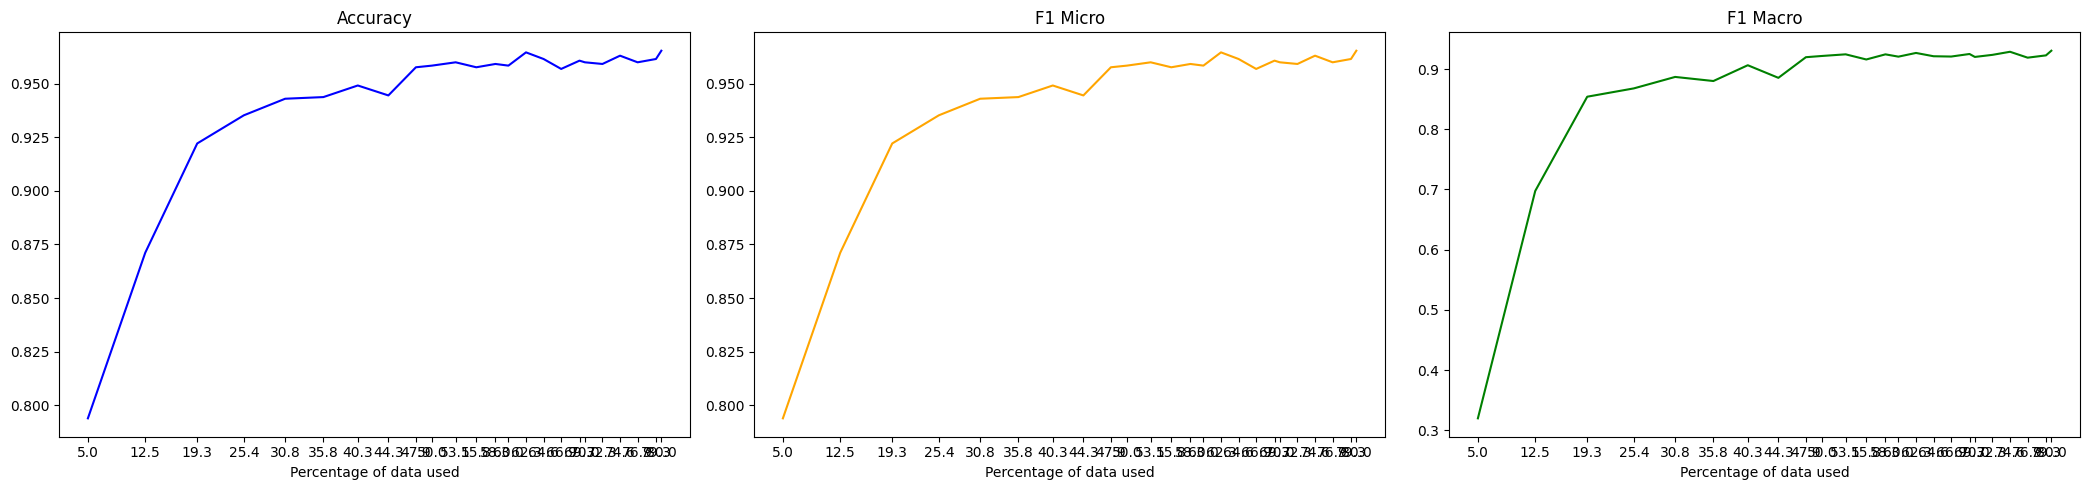

In [22]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.647, Accuracy: 0.7054, F1 Micro: 0.8127, F1 Macro: 0.7262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5731, Accuracy: 0.7374, F1 Micro: 0.8408, F1 Macro: 0.7949
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5493, Accuracy: 0.7917, F1 Micro: 0.8824, F1 Macro: 0.8802
Epoch 4/10, Train Loss: 0.5049, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Epoch 5/10, Train Loss: 0.4781, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 6/10, Train Loss: 0.4364, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4061, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Epoch 8/10, Train Loss: 0.4421, Accuracy: 0.7902, F1 Micro: 0.8825, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4208, Accuracy: 0.7939, F1 Micro: 0.8842, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6351, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5577, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5004, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4905, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4593, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4341, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4188, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2323, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.613, Accuracy: 0.7932, F1 Micro: 0.8831, F1 Macro: 0.881
Epoch 2/10, Train Loss: 0.5142, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.5203, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 4/10, Train Loss: 0.4604, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4419, Accuracy: 0.8013, F1 Micro: 0.8881, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3975, Accuracy: 0.8244, F1 Micro: 0.8992, F1 Macro: 0.8977
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3614, Accuracy: 0.8743, F1 Micro: 0.9253, F1 Macro: 0.9239
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3128, Accuracy: 0.9033, F1 Micro: 0.9407, F1 Macro: 0.9385
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2722, Accuracy: 0.9174, F1 Micro: 0.9492, F1 Macro: 0.9467
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5932, Accuracy: 0.6968, F1 Micro: 0.6968, F1 Macro: 0.4107
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5525, Accuracy: 0.6968, F1 Micro: 0.6968, F1 Macro: 0.4107
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4473, Accuracy: 0.6968, F1 Micro: 0.6968, F1 Macro: 0.4107
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4084, Accuracy: 0.6968, F1 Micro: 0.6968, F1 Macro: 0.4107
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2759, Accuracy: 0.7511, F1 Micro: 0.7511, F1 Macro: 0.6195
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2567, Accuracy: 0.8597, F1 Micro: 0.8597, F1 Macro: 0.8318
Epoch 7/10, Train Loss: 0.1806, Accuracy: 0.8552, F1 Micro: 0.8552, F1 Macro: 0.8189
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.212, Accuracy: 0.8778, F1 Micro: 0.8778, F1 Macro: 0.8548
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0847, Accuracy: 0.8824, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6039, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5116, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4975, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4419, Accuracy: 0.8065, F1 Micro: 0.8907, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3977, Accuracy: 0.8661, F1 Micro: 0.9212, F1 Macro: 0.9202
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3165, Accuracy: 0.904, F1 Micro: 0.9413, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2683, Accuracy: 0.9219, F1 Micro: 0.9521, F1 Macro: 0.9503
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.234, Accuracy: 0.9382, F1 Micro: 0.9619, F1 Macro: 0.9605
Epoch 9/10, Train Loss: 0.1898, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6221, Accuracy: 0.6816, F1 Micro: 0.6816, F1 Macro: 0.4053
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4725, Accuracy: 0.6816, F1 Micro: 0.6816, F1 Macro: 0.4053
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4587, Accuracy: 0.8341, F1 Micro: 0.8341, F1 Macro: 0.7781
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3369, Accuracy: 0.8879, F1 Micro: 0.8879, F1 Macro: 0.8732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1925, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8927
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1517, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1339, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8982
Epoch 8/10, Train Loss: 0.1118, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8942
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9193, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5765, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5075, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4862, Accuracy: 0.7969, F1 Micro: 0.8859, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3967, Accuracy: 0.8795, F1 Micro: 0.9279, F1 Macro: 0.9267
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3165, Accuracy: 0.9167, F1 Micro: 0.9486, F1 Macro: 0.9468
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2641, Accuracy: 0.9315, F1 Micro: 0.958, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2068, Accuracy: 0.942, F1 Micro: 0.964, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1705, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5551, Accuracy: 0.6857, F1 Micro: 0.6857, F1 Macro: 0.4068
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5038, Accuracy: 0.8041, F1 Micro: 0.8041, F1 Macro: 0.715
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3242, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.9009
Epoch 4/10, Train Loss: 0.2322, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8925
Epoch 5/10, Train Loss: 0.1336, Accuracy: 0.8939, F1 Micro: 0.8939, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.9347, F1 Micro: 0.9347, F1 Macro: 0.9237
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1389, Accuracy: 0.9429, F1 Micro: 0.9429, F1 Macro: 0.9362
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.106, Accuracy: 0.9429, F1 Micro: 0.9429, F1 Macro: 0.9354
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.9388, F1 Micro: 0.9388, F1 Macro: 0.9306
Epoch 10/10, Train Loss: 0.0699, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5702, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4806, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4455, Accuracy: 0.8318, F1 Micro: 0.9037, F1 Macro: 0.903
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3684, Accuracy: 0.907, F1 Micro: 0.9431, F1 Macro: 0.9413
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.285, Accuracy: 0.9219, F1 Micro: 0.9513, F1 Macro: 0.9493
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2302, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1748, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1524, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9731
Epoch 9/10, Train Loss: 0.116, Accuracy: 0.95

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5966, Accuracy: 0.6748, F1 Micro: 0.6748, F1 Macro: 0.4029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5294, Accuracy: 0.7033, F1 Micro: 0.7033, F1 Macro: 0.4903
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3747, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9111
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2478, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1412, Accuracy: 0.9309, F1 Micro: 0.9309, F1 Macro: 0.9242
Epoch 6/10, Train Loss: 0.1421, Accuracy: 0.9268, F1 Micro: 0.9268, F1 Macro: 0.9143
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1707, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro: 0.9328
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0939, Accuracy: 0.9431, F1 Micro: 0.9431, F1 Macro: 0.936
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1094, Accuracy: 0.9472, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5599, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4711, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3997, Accuracy: 0.8951, F1 Micro: 0.9361, F1 Macro: 0.9342
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3022, Accuracy: 0.9204, F1 Micro: 0.9507, F1 Macro: 0.949
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.248, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1767, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1523, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9741
Epoch 8/10, Train Loss: 0.1124, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9721
Epoch 9/10, Train Loss: 0.1, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9722
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5637, Accuracy: 0.6708, F1 Micro: 0.6708, F1 Macro: 0.4015
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4311, Accuracy: 0.8875, F1 Micro: 0.8875, F1 Macro: 0.876
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.255, Accuracy: 0.9292, F1 Micro: 0.9292, F1 Macro: 0.9206
Epoch 4/10, Train Loss: 0.1538, Accuracy: 0.925, F1 Micro: 0.925, F1 Macro: 0.9166
Epoch 5/10, Train Loss: 0.1343, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9089
Epoch 6/10, Train Loss: 0.1478, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9103
Epoch 7/10, Train Loss: 0.1331, Accuracy: 0.925, F1 Micro: 0.925, F1 Macro: 0.9156
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9292, F1 Micro: 0.9292, F1 Macro: 0.9228
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.096, Accuracy: 0.9292, F1 Micro: 0.9292, F1 Macro: 0.921
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0455, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5446, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4879, Accuracy: 0.7991, F1 Micro: 0.8871, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3949, Accuracy: 0.901, F1 Micro: 0.9396, F1 Macro: 0.9377
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2997, Accuracy: 0.9382, F1 Micro: 0.9618, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2215, Accuracy: 0.9509, F1 Micro: 0.9695, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1749, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9741
Epoch 7/10, Train Loss: 0.139, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1073, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0925, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5734, Accuracy: 0.6911, F1 Micro: 0.6911, F1 Macro: 0.4645
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3786, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9111
Epoch 3/10, Train Loss: 0.2239, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.9064
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1471, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro: 0.9312
Epoch 5/10, Train Loss: 0.1756, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.896
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1377, Accuracy: 0.9431, F1 Micro: 0.9431, F1 Macro: 0.9364
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.9268, F1 Micro: 0.9268, F1 Macro: 0.9204
Epoch 8/10, Train Loss: 0.0796, Accuracy: 0.935, F1 Micro: 0.935, F1 Macro: 0.9285
Epoch 9/10, Train Loss: 0.059, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro: 0.932
Epoch 10/10, Train Loss: 0.0497, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro: 0.9324

Sentiment analysis accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5461, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4767, Accuracy: 0.7984, F1 Micro: 0.8868, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.378, Accuracy: 0.9033, F1 Micro: 0.9396, F1 Macro: 0.9367
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2832, Accuracy: 0.9412, F1 Micro: 0.9633, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.205, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.168, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1304, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1065, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5742, Accuracy: 0.7194, F1 Micro: 0.7194, F1 Macro: 0.5472
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3647, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9146
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.203, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9334
Epoch 4/10, Train Loss: 0.1729, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9257
Epoch 5/10, Train Loss: 0.1568, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.914
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9295
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9317
Epoch 8/10, Train Loss: 0.094, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9166
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0847, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9387
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0677, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5537, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4653, Accuracy: 0.8259, F1 Micro: 0.9005, F1 Macro: 0.8991
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3538, Accuracy: 0.9204, F1 Micro: 0.9506, F1 Macro: 0.9477
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.253, Accuracy: 0.9487, F1 Micro: 0.9682, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1882, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9734
Epoch 6/10, Train Loss: 0.1538, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.111, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0793, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.58, Accuracy: 0.7385, F1 Micro: 0.7385, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.372, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9313
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1718, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.935
Epoch 4/10, Train Loss: 0.166, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8969
Epoch 5/10, Train Loss: 0.1559, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9075
Epoch 6/10, Train Loss: 0.1304, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8998
Epoch 7/10, Train Loss: 0.1424, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.907
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9109
Epoch 9/10, Train Loss: 0.0914, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9079
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0686, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9354

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5417, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4606, Accuracy: 0.8408, F1 Micro: 0.9082, F1 Macro: 0.9074
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3356, Accuracy: 0.9286, F1 Micro: 0.9553, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2379, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1891, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1374, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1052, Accuracy: 0.965, F1 Micro: 0.9782, F1 Macro: 0.9773
Epoch 8/10, Train Loss: 0.0966, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0789, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5889, Accuracy: 0.7273, F1 Micro: 0.7273, F1 Macro: 0.5667
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2985, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2161, Accuracy: 0.9526, F1 Micro: 0.9526, F1 Macro: 0.9468
Epoch 4/10, Train Loss: 0.1724, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9253
Epoch 5/10, Train Loss: 0.1316, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9226
Epoch 6/10, Train Loss: 0.1198, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9415
Epoch 7/10, Train Loss: 0.0656, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9183
Epoch 8/10, Train Loss: 0.1089, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9166
Epoch 9/10, Train Loss: 0.0659, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9299
Epoch 10/10, Train Loss: 0.0667, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9224

Sentiment analysis accuracy: 0.9526, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5431, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4508, Accuracy: 0.8601, F1 Micro: 0.9182, F1 Macro: 0.917
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3335, Accuracy: 0.9308, F1 Micro: 0.9572, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.237, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1842, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1413, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.109, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9799
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.95

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5442, Accuracy: 0.7701, F1 Micro: 0.7701, F1 Macro: 0.659
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3065, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9161
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2157, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9444
Epoch 4/10, Train Loss: 0.1695, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9378
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9247
Epoch 6/10, Train Loss: 0.1585, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9281
Epoch 7/10, Train Loss: 0.0969, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8813
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.954, F1 Micro: 0.954, F1 Macro: 0.948
Epoch 9/10, Train Loss: 0.0893, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9318
Epoch 10/10, Train Loss: 0.0659, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9233

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5406, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4387, Accuracy: 0.8802, F1 Micro: 0.929, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3153, Accuracy: 0.9353, F1 Micro: 0.9599, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2238, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.17, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.9783
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9776
Epoch 9/10, Train Loss: 0.0678, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.548, Accuracy: 0.7444, F1 Micro: 0.7444, F1 Macro: 0.5936
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2817, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9171
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2073, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9248
Epoch 4/10, Train Loss: 0.1324, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9213
Epoch 5/10, Train Loss: 0.1411, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9024
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1064, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9212
Epoch 7/10, Train Loss: 0.093, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.9165
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0691, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9308
Epoch 9/10, Train Loss: 0.0755, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9258
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0623, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5347, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4378, Accuracy: 0.8958, F1 Micro: 0.9371, F1 Macro: 0.9347
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3135, Accuracy: 0.9435, F1 Micro: 0.965, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.221, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.162, Accuracy: 0.965, F1 Micro: 0.9782, F1 Macro: 0.9772
Epoch 6/10, Train Loss: 0.1309, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0984, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Epoch 8/10, Train Loss: 0.0794, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0659, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5101, Accuracy: 0.8707, F1 Micro: 0.8707, F1 Macro: 0.8504
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2451, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1702, Accuracy: 0.9506, F1 Micro: 0.9506, F1 Macro: 0.9433
Epoch 4/10, Train Loss: 0.1481, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9144
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9085
Epoch 6/10, Train Loss: 0.0849, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.918
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9399
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9384
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9342
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0838, Accuracy: 0.9544, F1 Micro: 0.9544, F1 Macro: 0.9479

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5317, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4092, Accuracy: 0.9062, F1 Micro: 0.9429, F1 Macro: 0.9411
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2946, Accuracy: 0.9464, F1 Micro: 0.9666, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2084, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1558, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1147, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 7/10, Train Loss: 0.092, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9734
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.978
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5779, Accuracy: 0.6873, F1 Micro: 0.6873, F1 Macro: 0.4505
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2984, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9166
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1535, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9322
Epoch 4/10, Train Loss: 0.148, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9234
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9185
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9193
Epoch 7/10, Train Loss: 0.1308, Accuracy: 0.8803, F1 Micro: 0.8803, F1 Macro: 0.8735
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9278
Epoch 9/10, Train Loss: 0.078, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9282
Epoch 10/10, Train Loss: 0.0888, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9165

Sentiment analysis accuracy: 0.9382, F1 Micro: 0.93

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.54, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4167, Accuracy: 0.8996, F1 Micro: 0.9375, F1 Macro: 0.9348
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2828, Accuracy: 0.9412, F1 Micro: 0.9632, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2037, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1437, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.9779
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9786
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9732
Higher F1 achieved, saving 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5296, Accuracy: 0.8507, F1 Micro: 0.8507, F1 Macro: 0.8405
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2693, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9411
Epoch 3/10, Train Loss: 0.1741, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9374
Epoch 4/10, Train Loss: 0.1241, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9188
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9255
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9364
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0631, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9414
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9185
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.058, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9411

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5313, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4238, Accuracy: 0.8899, F1 Micro: 0.9317, F1 Macro: 0.9287
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2896, Accuracy: 0.939, F1 Micro: 0.962, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2048, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1493, Accuracy: 0.9673, F1 Micro: 0.9796, F1 Macro: 0.9785
Epoch 6/10, Train Loss: 0.1194, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.0938, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9779
Epoch 8/10, Train Loss: 0.0732, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.977
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Epoch 10/10, Train Loss: 0.053, Accuracy: 0.9673, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5504, Accuracy: 0.8848, F1 Micro: 0.8848, F1 Macro: 0.8712
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2343, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9211
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1895, Accuracy: 0.9383, F1 Micro: 0.9383, F1 Macro: 0.933
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1421, Accuracy: 0.9424, F1 Micro: 0.9424, F1 Macro: 0.9373
Epoch 5/10, Train Loss: 0.0901, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.9202
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9342, F1 Micro: 0.9342, F1 Macro: 0.9268
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.9465, F1 Micro: 0.9465, F1 Macro: 0.9417
Epoch 8/10, Train Loss: 0.0716, Accuracy: 0.9218, F1 Micro: 0.9218, F1 Macro: 0.916
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9245
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0523, Accuracy: 0.950

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5265, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4016, Accuracy: 0.8996, F1 Micro: 0.9368, F1 Macro: 0.9334
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2629, Accuracy: 0.9487, F1 Micro: 0.9682, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1913, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1372, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9789
Epoch 9/10, Train Loss: 0.0542, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5214, Accuracy: 0.8731, F1 Micro: 0.8731, F1 Macro: 0.8553
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2573, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9255
Epoch 3/10, Train Loss: 0.1642, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9189
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1472, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9331
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.113, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9319
Epoch 6/10, Train Loss: 0.1123, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9215
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.107, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9331
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.959, F1 Micro: 0.959, F1 Macro: 0.9531
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9515, F1 Micro: 0.9515, F1 Macro: 0.9455
Epoch 10/10, Train Loss: 0.0488, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5224, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3946, Accuracy: 0.9219, F1 Micro: 0.9515, F1 Macro: 0.9489
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2601, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1815, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9785
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0994, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9798
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Epoch 9/10, Train Loss: 0.0558, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9783
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4934, Accuracy: 0.8931, F1 Micro: 0.8931, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2259, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9185
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1753, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.929
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1354, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9283
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9167
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9216
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0767, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9401
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5231, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4024, Accuracy: 0.9219, F1 Micro: 0.9519, F1 Macro: 0.9499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2648, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.19, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1357, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9791
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9783
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5065, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2178, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9232
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.159, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.924
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1722, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9317
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9123
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1228, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9358
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1354, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9348
Epoch 8/10, Train Loss: 0.0754, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9273
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0789, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9362
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5185, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.382, Accuracy: 0.9256, F1 Micro: 0.9542, F1 Macro: 0.9528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2485, Accuracy: 0.9524, F1 Micro: 0.9706, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1018, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9804
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5051, Accuracy: 0.8706, F1 Micro: 0.8706, F1 Macro: 0.8625
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2565, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9382
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1859, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9435
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9477
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9608, F1 Micro: 0.9608, F1 Macro: 0.9561
Epoch 6/10, Train Loss: 0.1154, Accuracy: 0.9569, F1 Micro: 0.9569, F1 Macro: 0.9519
Epoch 7/10, Train Loss: 0.0899, Accuracy: 0.9569, F1 Micro: 0.9569, F1 Macro: 0.9516
Epoch 8/10, Train Loss: 0.0802, Accuracy: 0.9569, F1 Micro: 0.9569, F1 Macro: 0.9519
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9351
Epoch 10/10, Train Loss: 0.0563, Accuracy: 0.949, F1 Micro: 0.949, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5242, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3838, Accuracy: 0.9308, F1 Micro: 0.957, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2498, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1703, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9803
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9794
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9764
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5301, Accuracy: 0.8933, F1 Micro: 0.8933, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2538, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9253
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1643, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1465, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9387
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9393
Epoch 6/10, Train Loss: 0.0785, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9198
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0763, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9393
Epoch 8/10, Train Loss: 0.065, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9187
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0689, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9432
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5311, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3825, Accuracy: 0.9338, F1 Micro: 0.9589, F1 Macro: 0.9572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2416, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1738, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9753
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9738
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9758
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4733, Accuracy: 0.8935, F1 Micro: 0.8935, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2424, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9288
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1906, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9368
Epoch 4/10, Train Loss: 0.1358, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1294, Accuracy: 0.9506, F1 Micro: 0.9506, F1 Macro: 0.9447
Epoch 6/10, Train Loss: 0.0827, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9317
Epoch 7/10, Train Loss: 0.1027, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9361
Epoch 8/10, Train Loss: 0.0792, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9284
Epoch 9/10, Train Loss: 0.0615, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9324
Epoch 10/10, Train Loss: 0.0614, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9213

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5249, Accuracy: 0.7999, F1 Micro: 0.8875, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.352, Accuracy: 0.939, F1 Micro: 0.9622, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2356, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1575, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9782
Epoch 5/10, Train Loss: 0.1139, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9778
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0433

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4711, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9129
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2338, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9251
Epoch 3/10, Train Loss: 0.1647, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.905
Epoch 4/10, Train Loss: 0.1296, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9133
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1169, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9317
Epoch 6/10, Train Loss: 0.1147, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9251
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9284
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9251
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8977
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0489, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9328

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5225, Accuracy: 0.7976, F1 Micro: 0.8864, F1 Macro: 0.8849
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3686, Accuracy: 0.9308, F1 Micro: 0.9571, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.234, Accuracy: 0.9531, F1 Micro: 0.971, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1607, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9759
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.9576, F1 Micro: 0.9732, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.965, F1 Micro: 0.9778, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9778
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5003, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8935
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2438, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.915
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1858, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9107
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1465, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9302
Epoch 5/10, Train Loss: 0.1103, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9265
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9146
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.915
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.07, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9471
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9265
Epoch 10/10, Train Loss: 0.0532, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Ma

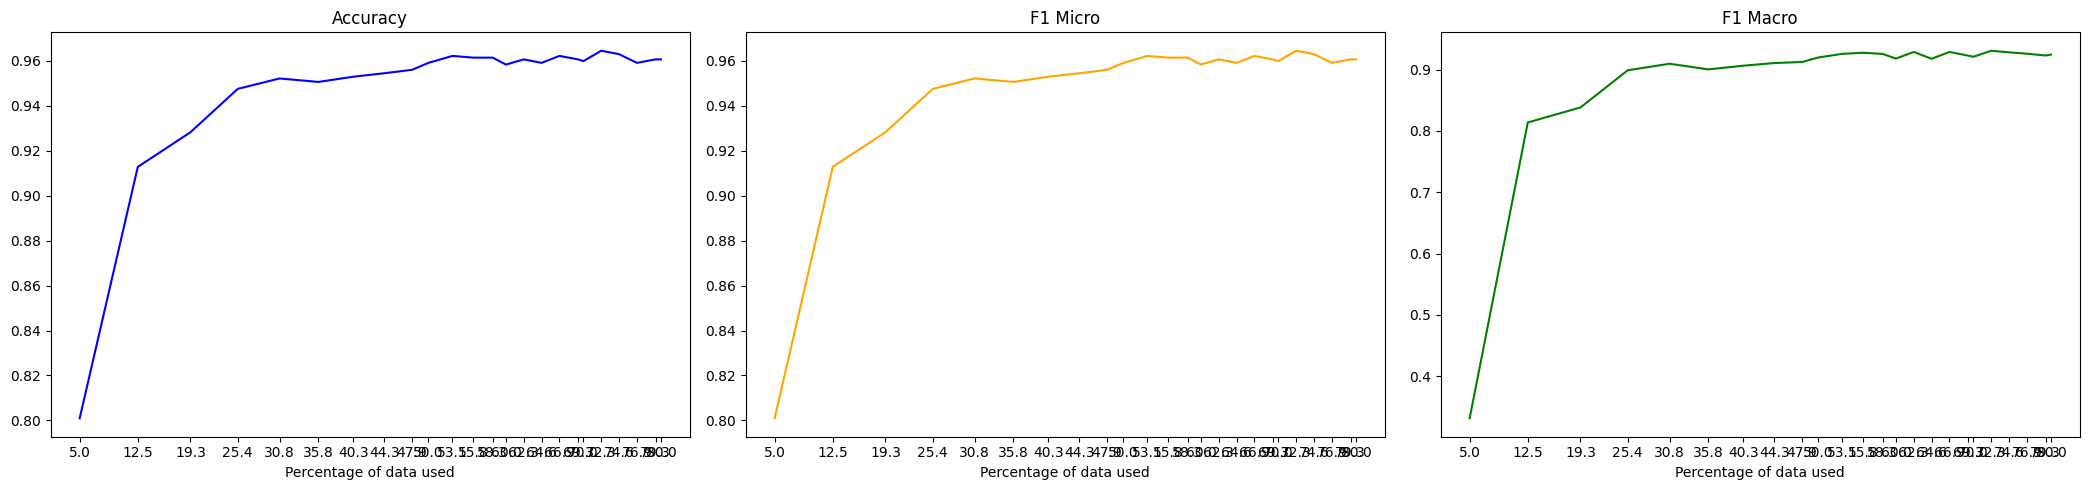

In [23]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6791, Accuracy: 0.7746, F1 Micro: 0.8722, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5752, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.512, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4609, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4635, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4127, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3898, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4151, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.8159, Accuracy: 0.3333, F1 Micro: 0.3333, F1 Macro: 0.25
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6264, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5442, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5154, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4038, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3617, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3192, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2942, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3391, Accuracy: 0.66

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6303, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5033, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4778, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4662, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4217, Accuracy: 0.7976, F1 Micro: 0.8864, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4115, Accuracy: 0.8125, F1 Micro: 0.8935, F1 Macro: 0.8921
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3785, Accuracy: 0.8237, F1 Micro: 0.8979, F1 Macro: 0.8955
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3174, Accuracy: 0.8497, F1 Micro: 0.9108, F1 Macro: 0.9075
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6228, Accuracy: 0.6984, F1 Micro: 0.6984, F1 Macro: 0.4112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4821, Accuracy: 0.6984, F1 Micro: 0.6984, F1 Macro: 0.4112
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4524, Accuracy: 0.8148, F1 Micro: 0.8148, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.252, Accuracy: 0.8466, F1 Micro: 0.8466, F1 Macro: 0.7932
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2047, Accuracy: 0.8519, F1 Micro: 0.8519, F1 Macro: 0.8096
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1335, Accuracy: 0.8677, F1 Micro: 0.8677, F1 Macro: 0.8243
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1019, Accuracy: 0.8836, F1 Micro: 0.8836, F1 Macro: 0.8574
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8688
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.8571, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5997, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5048, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5071, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4529, Accuracy: 0.8051, F1 Micro: 0.8901, F1 Macro: 0.8887
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3959, Accuracy: 0.8341, F1 Micro: 0.9044, F1 Macro: 0.9031
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3383, Accuracy: 0.8638, F1 Micro: 0.9198, F1 Macro: 0.9181
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2899, Accuracy: 0.9033, F1 Micro: 0.9411, F1 Macro: 0.9389
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2365, Accuracy: 0.9256, F1 Micro: 0.9542, F1 Macro: 0.9518
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6222, Accuracy: 0.6756, F1 Micro: 0.6756, F1 Macro: 0.4032
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4966, Accuracy: 0.76, F1 Micro: 0.76, F1 Macro: 0.6577
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3499, Accuracy: 0.8267, F1 Micro: 0.8267, F1 Macro: 0.7772
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2118, Accuracy: 0.9244, F1 Micro: 0.9244, F1 Macro: 0.9135
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.9067
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9231
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.8711, F1 Micro: 0.8711, F1 Macro: 0.8378
Epoch 8/10, Train Loss: 0.0388, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.9081
Epoch 9/10, Train Loss: 0.0983, Accuracy: 0.9244, F1 Micro: 0.9244, F1 Macro: 0.9122
Epoch 10/10, Train Loss: 0.07, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8654

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5847, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4983, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4647, Accuracy: 0.8013, F1 Micro: 0.8882, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4134, Accuracy: 0.8222, F1 Micro: 0.8978, F1 Macro: 0.8961
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3692, Accuracy: 0.8631, F1 Micro: 0.9188, F1 Macro: 0.9164
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2893, Accuracy: 0.9211, F1 Micro: 0.9511, F1 Macro: 0.9486
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2305, Accuracy: 0.939, F1 Micro: 0.9622, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1799, Accuracy: 0.9435, F1 Micro: 0.9647, F1 Macro: 0.9624
Epoch 9/10, Train Loss: 0.1493, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5784, Accuracy: 0.684, F1 Micro: 0.684, F1 Macro: 0.4062
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4326, Accuracy: 0.768, F1 Micro: 0.768, F1 Macro: 0.6783
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2909, Accuracy: 0.892, F1 Micro: 0.892, F1 Macro: 0.8793
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1703, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.905
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8989
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.905
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.905
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0841, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.9093
Epoch 9/10, Train Loss: 0.0599, Accuracy: 0.896, F1 Micro: 0.896, F1 Macro: 0.8771
Higher F1 achieved, saving m

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5667, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4769, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4504, Accuracy: 0.8073, F1 Micro: 0.8911, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3905, Accuracy: 0.869, F1 Micro: 0.9221, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2878, Accuracy: 0.9249, F1 Micro: 0.9535, F1 Macro: 0.9509
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2299, Accuracy: 0.939, F1 Micro: 0.962, F1 Macro: 0.9597
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1838, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1517, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6254, Accuracy: 0.6855, F1 Micro: 0.6855, F1 Macro: 0.4067
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4492, Accuracy: 0.7782, F1 Micro: 0.7782, F1 Macro: 0.6887
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2807, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8907
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1548, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8935
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8928
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0611, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.9077
Epoch 7/10, Train Loss: 0.1027, Accuracy: 0.879, F1 Micro: 0.879, F1 Macro: 0.8507
Epoch 8/10, Train Loss: 0.0808, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8942
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.9041
Epoch 10/10, Train Loss: 0.053, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5449, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4957, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4219, Accuracy: 0.849, F1 Micro: 0.9115, F1 Macro: 0.9096
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3349, Accuracy: 0.9189, F1 Micro: 0.95, F1 Macro: 0.9476
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.259, Accuracy: 0.9487, F1 Micro: 0.9682, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2008, Accuracy: 0.9494, F1 Micro: 0.9685, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1556, Accuracy: 0.9509, F1 Micro: 0.9693, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1187, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5576, Accuracy: 0.6623, F1 Micro: 0.6623, F1 Macro: 0.4329
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3398, Accuracy: 0.864, F1 Micro: 0.864, F1 Macro: 0.859
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2455, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Macro: 0.9071
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1366, Accuracy: 0.9298, F1 Micro: 0.9298, F1 Macro: 0.9221
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9426
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8946
Epoch 7/10, Train Loss: 0.1205, Accuracy: 0.9386, F1 Micro: 0.9386, F1 Macro: 0.9337
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9193
Epoch 9/10, Train Loss: 0.0663, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9158
Epoch 10/10, Train Loss: 0.0645, Accuracy: 0.9254, F1 Micro: 0.9254, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5616, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4788, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4135, Accuracy: 0.8698, F1 Micro: 0.9231, F1 Macro: 0.9215
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3248, Accuracy: 0.9241, F1 Micro: 0.9529, F1 Macro: 0.9502
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2359, Accuracy: 0.9412, F1 Micro: 0.9633, F1 Macro: 0.9612
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1745, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9713
Epoch 7/10, Train Loss: 0.1378, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9691
Epoch 8/10, Train Loss: 0.1126, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9695
Epoch 9/10, Train Loss: 0.0892, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.971
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5947, Accuracy: 0.7012, F1 Micro: 0.7012, F1 Macro: 0.5164
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3375, Accuracy: 0.888, F1 Micro: 0.888, F1 Macro: 0.8623
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1988, Accuracy: 0.9253, F1 Micro: 0.9253, F1 Macro: 0.9147
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1317, Accuracy: 0.9378, F1 Micro: 0.9378, F1 Macro: 0.9309
Epoch 5/10, Train Loss: 0.1281, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8987
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9237
Epoch 7/10, Train Loss: 0.0969, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8812
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9261
Epoch 9/10, Train Loss: 0.0302, Accuracy: 0.9212, F1 Micro: 0.9212, F1 Macro: 0.9097
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.042, Accuracy: 0.9461, F1 Micro: 0.9461, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5379, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4794, Accuracy: 0.7984, F1 Micro: 0.8868, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4012, Accuracy: 0.8884, F1 Micro: 0.9324, F1 Macro: 0.9303
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2931, Accuracy: 0.9338, F1 Micro: 0.9587, F1 Macro: 0.956
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2158, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9673
Epoch 6/10, Train Loss: 0.1602, Accuracy: 0.9479, F1 Micro: 0.9671, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.136, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1003, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9731
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5456, Accuracy: 0.772, F1 Micro: 0.772, F1 Macro: 0.67
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2942, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9236
Epoch 3/10, Train Loss: 0.1635, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9161
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1452, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9253
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9419
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9357
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1072, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9408
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9462
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9308
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5593, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4757, Accuracy: 0.8162, F1 Micro: 0.8954, F1 Macro: 0.894
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3686, Accuracy: 0.9196, F1 Micro: 0.9507, F1 Macro: 0.9488
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2696, Accuracy: 0.9457, F1 Micro: 0.966, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1818, Accuracy: 0.9516, F1 Micro: 0.9696, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1425, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1132, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0975, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9732
Epoch 9/10, Train Loss: 0.0771, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5442, Accuracy: 0.7188, F1 Micro: 0.7188, F1 Macro: 0.523
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2995, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9028
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9021
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9187
Epoch 5/10, Train Loss: 0.1241, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9093
Epoch 6/10, Train Loss: 0.1285, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9028
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9334
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0684, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9462
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9258
Epoch 10/10, Train Loss: 0.0693, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5477, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4738, Accuracy: 0.8021, F1 Micro: 0.8885, F1 Macro: 0.887
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.376, Accuracy: 0.9144, F1 Micro: 0.9477, F1 Macro: 0.9461
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2634, Accuracy: 0.9442, F1 Micro: 0.9654, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1891, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1438, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9561, F1 Micro: 0.9723, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0971, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.538, Accuracy: 0.7097, F1 Micro: 0.7097, F1 Macro: 0.5196
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2687, Accuracy: 0.9274, F1 Micro: 0.9274, F1 Macro: 0.918
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1906, Accuracy: 0.9395, F1 Micro: 0.9395, F1 Macro: 0.9334
Epoch 4/10, Train Loss: 0.1032, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.9065
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.9008
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9395, F1 Micro: 0.9395, F1 Macro: 0.9315
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.9071
Epoch 8/10, Train Loss: 0.1002, Accuracy: 0.9274, F1 Micro: 0.9274, F1 Macro: 0.9164
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.064, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9362
Epoch 10/10, Train Loss: 0.0628, Accuracy: 0.9355, F1 Micro: 0.9355, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5311, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4662, Accuracy: 0.8259, F1 Micro: 0.8997, F1 Macro: 0.8982
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3524, Accuracy: 0.9196, F1 Micro: 0.9512, F1 Macro: 0.9497
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2501, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9705
Epoch 5/10, Train Loss: 0.1868, Accuracy: 0.9531, F1 Micro: 0.9706, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1388, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9719
Epoch 7/10, Train Loss: 0.1039, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0945, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.073, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5788, Accuracy: 0.7083, F1 Micro: 0.7083, F1 Macro: 0.5058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.274, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9233
Epoch 3/10, Train Loss: 0.1757, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9193
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1533, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9278
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1408, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9355
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.129, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9347
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9389
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0696, Accuracy: 0.947, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5404, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4486, Accuracy: 0.8408, F1 Micro: 0.9075, F1 Macro: 0.9061
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3516, Accuracy: 0.9249, F1 Micro: 0.9539, F1 Macro: 0.9518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2321, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9696
Epoch 5/10, Train Loss: 0.1637, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9736
Epoch 7/10, Train Loss: 0.1084, Accuracy: 0.9531, F1 Micro: 0.9704, F1 Macro: 0.9681
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9568, F1 Micro: 0.9726, F1 Macro: 0.9702
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5402, Accuracy: 0.8722, F1 Micro: 0.8722, F1 Macro: 0.853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.259, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1637, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.9032
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.177, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9267
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9024
Epoch 6/10, Train Loss: 0.1117, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.9151
Epoch 7/10, Train Loss: 0.0872, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.9146
Epoch 8/10, Train Loss: 0.0869, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9181
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9176
Epoch 10/10, Train Loss: 0.057, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9111

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5461, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4515, Accuracy: 0.8452, F1 Micro: 0.91, F1 Macro: 0.9086
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3328, Accuracy: 0.9382, F1 Micro: 0.9619, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2285, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1724, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9744
Epoch 6/10, Train Loss: 0.1214, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9715
Epoch 7/10, Train Loss: 0.0986, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9726
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5547, Accuracy: 0.874, F1 Micro: 0.874, F1 Macro: 0.8559
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2475, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9036
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1748, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9135
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1456, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9271
Epoch 5/10, Train Loss: 0.1103, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9024
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9118
Epoch 7/10, Train Loss: 0.0881, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8983
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9221
Epoch 9/10, Train Loss: 0.0624, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9221
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.041, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5267, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4373, Accuracy: 0.8735, F1 Micro: 0.9239, F1 Macro: 0.9212
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3179, Accuracy: 0.9472, F1 Micro: 0.9673, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2212, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1548, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9745
Epoch 6/10, Train Loss: 0.1246, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9771
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.9688, F1 Micro: 0.9803, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5779, Accuracy: 0.8199, F1 Micro: 0.8199, F1 Macro: 0.758
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.305, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.9037
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1764, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9028
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9188
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1503, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9318
Epoch 6/10, Train Loss: 0.0969, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9153
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9386
Epoch 8/10, Train Loss: 0.0818, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9237
Epoch 9/10, Train Loss: 0.0855, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9224
Epoch 10/10, Train Loss: 0.0629, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5355, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.429, Accuracy: 0.8929, F1 Micro: 0.936, F1 Macro: 0.9344
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2928, Accuracy: 0.9442, F1 Micro: 0.9651, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1972, Accuracy: 0.9531, F1 Micro: 0.9705, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1493, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1159, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0941, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9756
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5158, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.264, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8993
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1754, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.927
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1041, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9339
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1517, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9328
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0891, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9339
Epoch 8/10, Train Loss: 0.0805, Accuracy: 0.9301, F1 Micro: 0.9301, F1 Macro: 0.919
Epoch 9/10, Train Loss: 0.0772, Accuracy: 0.9007, F1 Micro: 0.9007, F1 Macro: 0.88
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.533, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4348, Accuracy: 0.8728, F1 Micro: 0.9249, F1 Macro: 0.9234
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3033, Accuracy: 0.9487, F1 Micro: 0.9683, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2002, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9721
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.117, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Epoch 7/10, Train Loss: 0.0957, Accuracy: 0.9546, F1 Micro: 0.9711, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0798, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9779
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4606, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8992
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2287, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9198
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1622, Accuracy: 0.9572, F1 Micro: 0.9572, F1 Macro: 0.9515
Epoch 4/10, Train Loss: 0.1368, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9234
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.944
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9293
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.908
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9373
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9322
Epoch 10/10, Train Loss: 0.055, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.943

Sentiment analysis accuracy: 0.9572, F1 Micro: 0.9572, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5308, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4196, Accuracy: 0.9003, F1 Micro: 0.9392, F1 Macro: 0.9367
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.28, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2005, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1441, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1116, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0865, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.067, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5013, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8989
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2267, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9237
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1547, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9253
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9322
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1109, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9326
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9451
Epoch 7/10, Train Loss: 0.1208, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.94
Epoch 8/10, Train Loss: 0.0878, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9322
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9278
Epoch 10/10, Train Loss: 0.0565, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5273, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4203, Accuracy: 0.9167, F1 Micro: 0.949, F1 Macro: 0.9474
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2626, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1789, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0996, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9779
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9742
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9728
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5187, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.9042
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2752, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9369
Epoch 3/10, Train Loss: 0.1666, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9212
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1115, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9365
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1082, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9406
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9406
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9511, F1 Micro: 0.9511, F1 Macro: 0.9446
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0643, Accuracy: 0.9586, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5349, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4188, Accuracy: 0.8787, F1 Micro: 0.9275, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2788, Accuracy: 0.9464, F1 Micro: 0.9669, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1844, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.974
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9772
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Epoch 8/10, Train Loss: 0.0684, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Epoch 10/10, Train Loss: 0.0498, Accuracy: 0.9635, F1 Mi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5295, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2536, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.9156
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1851, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9288
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1444, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9365
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.924
Epoch 6/10, Train Loss: 0.0797, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9227
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9276
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9227
Epoch 9/10, Train Loss: 0.0652, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.9112
Epoch 10/10, Train Loss: 0.0722, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9308

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5163, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4107, Accuracy: 0.904, F1 Micro: 0.9412, F1 Macro: 0.9387
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2595, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1798, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9747
Epoch 5/10, Train Loss: 0.1349, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1042, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9794
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.975
Epoch 8/10, Train Loss: 0.0685, Accuracy: 0.9665, F1 Micro: 0.9787, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9688, F1 Micro: 0.9802, F1 Macro: 0.9789
Epoch 10/10, Train Loss: 0.046, Accuracy: 0.9665, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5069, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.9064
Epoch 2/10, Train Loss: 0.2148, Accuracy: 0.8794, F1 Micro: 0.8794, F1 Macro: 0.8724
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1889, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9246
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1153, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9268
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9377
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1097, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9388
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9385
Epoch 8/10, Train Loss: 0.0731, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9312
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9141
Epoch 10/10, Train Loss: 0.0695, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5318, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3916, Accuracy: 0.9174, F1 Micro: 0.9498, F1 Macro: 0.9484
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2539, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9598, F1 Micro: 0.9745, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5017, Accuracy: 0.8797, F1 Micro: 0.8797, F1 Macro: 0.8707
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2315, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9272
Epoch 3/10, Train Loss: 0.1748, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.9177
Epoch 4/10, Train Loss: 0.1306, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9055
Epoch 5/10, Train Loss: 0.0959, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9104
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1246, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9284
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8984
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9134
Epoch 9/10, Train Loss: 0.0677, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9217
Epoch 10/10, Train Loss: 0.0505, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9248

Sentiment analysis accuracy: 0.9361, F1 Micro: 0.93

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5272, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3984, Accuracy: 0.9182, F1 Micro: 0.9496, F1 Macro: 0.9476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2541, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9791
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9785
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.9743
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9771
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4711, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9328
Epoch 2/10, Train Loss: 0.2254, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.9065
Epoch 3/10, Train Loss: 0.1838, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9292
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1349, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9328
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.9052
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9276
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9213
Epoch 8/10, Train Loss: 0.0855, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9252
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0664, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9372

Sentiment analysis accuracy: 0.9436, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5216, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4004, Accuracy: 0.9226, F1 Micro: 0.9522, F1 Macro: 0.9499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2488, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1765, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9792
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9772
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9758
Epoch 10/10, Train Loss: 0.0453, Accuracy: 0.9673, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4825, Accuracy: 0.8833, F1 Micro: 0.8833, F1 Macro: 0.8753
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2189, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.148, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9301
Epoch 4/10, Train Loss: 0.1147, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9227
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0967, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9398
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0762, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9395
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.943
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5271, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3958, Accuracy: 0.9226, F1 Micro: 0.9526, F1 Macro: 0.951
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2482, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0519, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9788
Higher F1 achieved, saving m

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4808, Accuracy: 0.8985, F1 Micro: 0.8985, F1 Macro: 0.8912
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2266, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.9185
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1604, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.922
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1441, Accuracy: 0.9511, F1 Micro: 0.9511, F1 Macro: 0.945
Epoch 5/10, Train Loss: 0.1248, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9263
Epoch 6/10, Train Loss: 0.1309, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9335
Epoch 7/10, Train Loss: 0.0865, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9412
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9244
Epoch 9/10, Train Loss: 0.068, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9134
Epoch 10/10, Train Loss: 0.063, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9267

Sentiment analysis ac

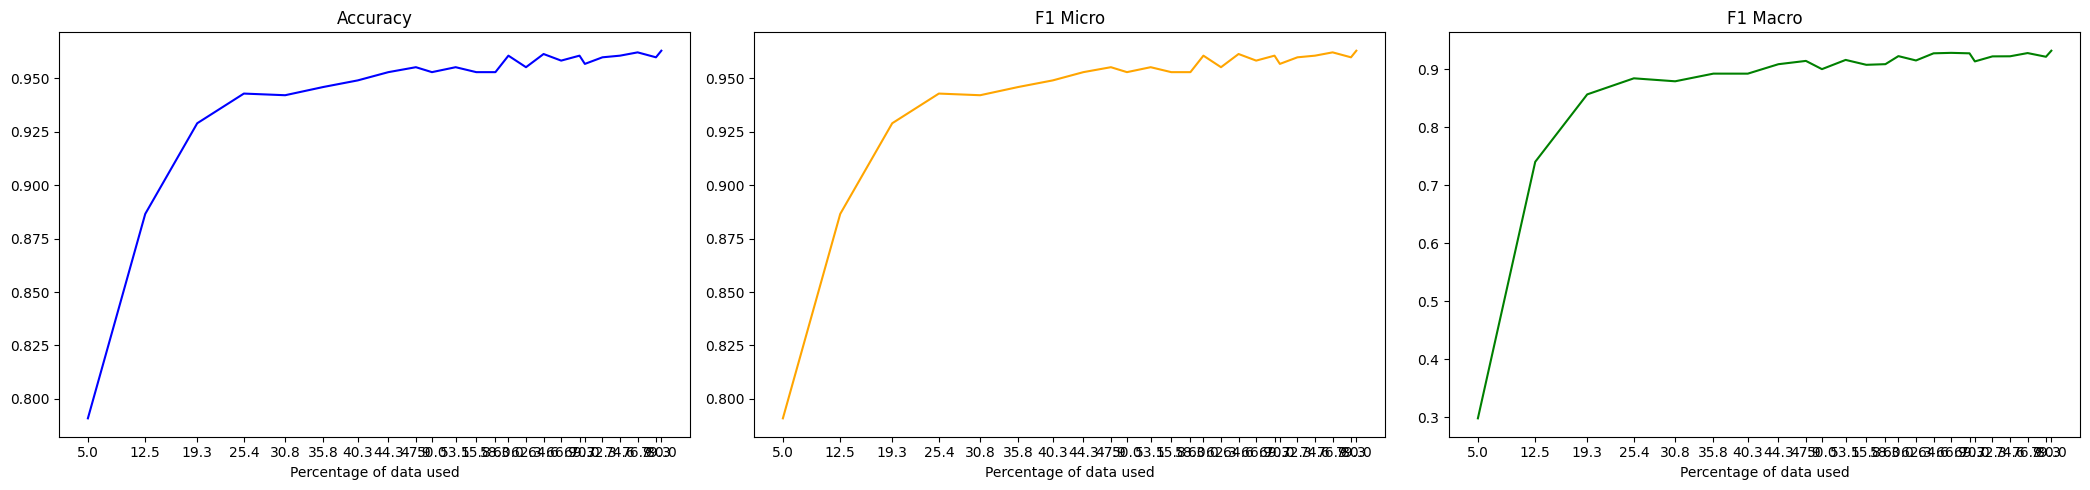

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6456, Accuracy: 0.7865, F1 Micro: 0.8804, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5639, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5346, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5259, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4788, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 6/10, Train Loss: 0.477, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 7/10, Train Loss: 0.4707, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4588, Accuracy: 0.7909, F1 Micro: 0.883, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4215, Accuracy: 0.7932, F1 Micro: 0.8839, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7056, Accuracy: 0.44, F1 Micro: 0.44, F1 Macro: 0.4318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5997, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5241, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5185, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.494, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4806, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4617, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.422, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3873, Accuracy: 0.84, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5989, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.5124, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4913, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4831, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4735, Accuracy: 0.8103, F1 Micro: 0.8925, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3998, Accuracy: 0.8147, F1 Micro: 0.8931, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3741, Accuracy: 0.8311, F1 Micro: 0.9024, F1 Macro: 0.9006
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3304, Accuracy: 0.8616, F1 Micro: 0.9181, F1 Macro: 0.9164
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2934, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5527, Accuracy: 0.7151, F1 Micro: 0.7151, F1 Macro: 0.4169
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5656, Accuracy: 0.7151, F1 Micro: 0.7151, F1 Macro: 0.4169
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5343, Accuracy: 0.7151, F1 Micro: 0.7151, F1 Macro: 0.4169
Epoch 4/10, Train Loss: 0.5062, Accuracy: 0.7043, F1 Micro: 0.7043, F1 Macro: 0.4132
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.393, Accuracy: 0.7903, F1 Micro: 0.7903, F1 Macro: 0.6866
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3096, Accuracy: 0.8763, F1 Micro: 0.8763, F1 Macro: 0.8474
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1388, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0903, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8919
Epoch 9/10, Train Loss: 0.1307, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.8845
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5822, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.4916, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4882, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4556, Accuracy: 0.8013, F1 Micro: 0.8878, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4261, Accuracy: 0.8207, F1 Micro: 0.8963, F1 Macro: 0.8946
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3644, Accuracy: 0.8571, F1 Micro: 0.9159, F1 Macro: 0.9142
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3037, Accuracy: 0.8862, F1 Micro: 0.9313, F1 Macro: 0.9291
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2618, Accuracy: 0.9152, F1 Micro: 0.9478, F1 Macro: 0.946
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2149, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6025, Accuracy: 0.654, F1 Micro: 0.654, F1 Macro: 0.3954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.516, Accuracy: 0.654, F1 Micro: 0.654, F1 Macro: 0.3954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4773, Accuracy: 0.654, F1 Micro: 0.654, F1 Macro: 0.3954
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3734, Accuracy: 0.8626, F1 Micro: 0.8626, F1 Macro: 0.8352
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2571, Accuracy: 0.9479, F1 Micro: 0.9479, F1 Macro: 0.9433
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1996, Accuracy: 0.9526, F1 Micro: 0.9526, F1 Macro: 0.9473
Epoch 7/10, Train Loss: 0.1473, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9246
Epoch 8/10, Train Loss: 0.1222, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9272
Epoch 9/10, Train Loss: 0.0782, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.9008
Epoch 10/10, Train Loss: 0.0721, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5647, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.5026, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4645, Accuracy: 0.7991, F1 Micro: 0.8859, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4095, Accuracy: 0.8199, F1 Micro: 0.8955, F1 Macro: 0.8931
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3672, Accuracy: 0.872, F1 Micro: 0.9237, F1 Macro: 0.9219
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2948, Accuracy: 0.8996, F1 Micro: 0.9378, F1 Macro: 0.9347
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2449, Accuracy: 0.9278, F1 Micro: 0.9552, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1847, Accuracy: 0.9427, F1 Micro: 0.9646, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1505, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5779, Accuracy: 0.6639, F1 Micro: 0.6639, F1 Macro: 0.399
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5114, Accuracy: 0.7418, F1 Micro: 0.7418, F1 Macro: 0.6327
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3177, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.9078
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2558, Accuracy: 0.9426, F1 Micro: 0.9426, F1 Macro: 0.9368
Epoch 5/10, Train Loss: 0.2134, Accuracy: 0.8975, F1 Micro: 0.8975, F1 Macro: 0.8764
Epoch 6/10, Train Loss: 0.1592, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9265
Epoch 7/10, Train Loss: 0.1329, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.93
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9426, F1 Micro: 0.9426, F1 Macro: 0.9368
Epoch 9/10, Train Loss: 0.0652, Accuracy: 0.873, F1 Micro: 0.873, F1 Macro: 0.8413
Epoch 10/10, Train Loss: 0.0751, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5634, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5061, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4558, Accuracy: 0.8103, F1 Micro: 0.891, F1 Macro: 0.8887
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3878, Accuracy: 0.8594, F1 Micro: 0.916, F1 Macro: 0.9135
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2991, Accuracy: 0.904, F1 Micro: 0.9404, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2458, Accuracy: 0.9353, F1 Micro: 0.9598, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1912, Accuracy: 0.9472, F1 Micro: 0.9669, F1 Macro: 0.9644
Epoch 8/10, Train Loss: 0.1522, Accuracy: 0.9449, F1 Micro: 0.9655, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1179, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6044, Accuracy: 0.6759, F1 Micro: 0.6759, F1 Macro: 0.4033
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3893, Accuracy: 0.8933, F1 Micro: 0.8933, F1 Macro: 0.8808
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2213, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9287
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9198
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.9124
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9188
Epoch 7/10, Train Loss: 0.0642, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9203
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9236
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.938
Epoch 10/10, Train Loss: 0.0604, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9334

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5538, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4795, Accuracy: 0.7939, F1 Micro: 0.8835, F1 Macro: 0.8813
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4223, Accuracy: 0.8259, F1 Micro: 0.8989, F1 Macro: 0.8965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3603, Accuracy: 0.8988, F1 Micro: 0.938, F1 Macro: 0.9348
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2691, Accuracy: 0.9412, F1 Micro: 0.9635, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1974, Accuracy: 0.9449, F1 Micro: 0.9657, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1454, Accuracy: 0.9494, F1 Micro: 0.9683, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1296, Accuracy: 0.9546, F1 Micro: 0.9714, F1 Macro: 0.9688
Epoch 9/10, Train Loss: 0.0981, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6275, Accuracy: 0.6756, F1 Micro: 0.6756, F1 Macro: 0.4032
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4365, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8908
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2491, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9323
Epoch 4/10, Train Loss: 0.2294, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9045
Epoch 5/10, Train Loss: 0.1531, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9052
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1243, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.936
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9258
Epoch 8/10, Train Loss: 0.0713, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9238
Epoch 9/10, Train Loss: 0.0881, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9242
Epoch 10/10, Train Loss: 0.0851, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9211

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5431, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4726, Accuracy: 0.7939, F1 Micro: 0.8836, F1 Macro: 0.8815
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4208, Accuracy: 0.843, F1 Micro: 0.9086, F1 Macro: 0.9068
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3281, Accuracy: 0.91, F1 Micro: 0.9447, F1 Macro: 0.9416
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2559, Accuracy: 0.9427, F1 Micro: 0.9642, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1948, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1459, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.975
Epoch 8/10, Train Loss: 0.1144, Accuracy: 0.9479, F1 Micro: 0.9671, F1 Macro: 0.9636
Epoch 9/10, Train Loss: 0.0978, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5322, Accuracy: 0.6846, F1 Micro: 0.6846, F1 Macro: 0.4179
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3363, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9317
Epoch 3/10, Train Loss: 0.2283, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.924
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.935
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1723, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9388
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8893
Epoch 7/10, Train Loss: 0.1176, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9151
Epoch 8/10, Train Loss: 0.0831, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9255
Epoch 9/10, Train Loss: 0.096, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9313
Epoch 10/10, Train Loss: 0.0715, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9115

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5481, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.485, Accuracy: 0.8013, F1 Micro: 0.8862, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4233, Accuracy: 0.8609, F1 Micro: 0.9176, F1 Macro: 0.9158
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3111, Accuracy: 0.9315, F1 Micro: 0.9581, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2319, Accuracy: 0.9576, F1 Micro: 0.9737, F1 Macro: 0.9726
Epoch 6/10, Train Loss: 0.1839, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1324, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1028, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0949, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5992, Accuracy: 0.668, F1 Micro: 0.668, F1 Macro: 0.4005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4387, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9305
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9455
Epoch 4/10, Train Loss: 0.1912, Accuracy: 0.9426, F1 Micro: 0.9426, F1 Macro: 0.9368
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9262, F1 Micro: 0.9262, F1 Macro: 0.9196
Epoch 6/10, Train Loss: 0.1056, Accuracy: 0.9303, F1 Micro: 0.9303, F1 Macro: 0.9246
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.959, F1 Micro: 0.959, F1 Macro: 0.9541
Epoch 8/10, Train Loss: 0.1042, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9452
Epoch 9/10, Train Loss: 0.0853, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9452
Epoch 10/10, Train Loss: 0.0518, Accuracy: 0.9467, F1 Micro: 0.9467, F1 Macro: 0.9397

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5337, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4742, Accuracy: 0.8065, F1 Micro: 0.8906, F1 Macro: 0.889
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.386, Accuracy: 0.8981, F1 Micro: 0.9386, F1 Macro: 0.9371
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2734, Accuracy: 0.9457, F1 Micro: 0.9665, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1948, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9744
Epoch 6/10, Train Loss: 0.1454, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9699
Epoch 7/10, Train Loss: 0.1146, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0734, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9733
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5568, Accuracy: 0.6743, F1 Micro: 0.6743, F1 Macro: 0.4138
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3873, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9322
Epoch 3/10, Train Loss: 0.206, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9224
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9403
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9318
Epoch 6/10, Train Loss: 0.1145, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9318
Epoch 7/10, Train Loss: 0.0918, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9092
Epoch 8/10, Train Loss: 0.0945, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9285
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9179
Epoch 10/10, Train Loss: 0.0782, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9169

Sentiment analysis accuracy: 0.9464, F1 Micro: 0.946

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5432, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.481, Accuracy: 0.8028, F1 Micro: 0.8881, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3936, Accuracy: 0.901, F1 Micro: 0.9392, F1 Macro: 0.9366
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2743, Accuracy: 0.9353, F1 Micro: 0.9596, F1 Macro: 0.9574
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2034, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1487, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1169, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0959, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5708, Accuracy: 0.6962, F1 Micro: 0.6962, F1 Macro: 0.4828
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3153, Accuracy: 0.8885, F1 Micro: 0.8885, F1 Macro: 0.8815
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1877, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1434, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9287
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1119, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9313
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.114, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9324
Epoch 7/10, Train Loss: 0.138, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.9052
Epoch 8/10, Train Loss: 0.1103, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9243
Epoch 9/10, Train Loss: 0.0918, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9218
Epoch 10/10, Train Loss: 0.0636, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.536, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4718, Accuracy: 0.8147, F1 Micro: 0.8937, F1 Macro: 0.8918
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3702, Accuracy: 0.9226, F1 Micro: 0.9522, F1 Macro: 0.95
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2691, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1867, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.141, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9752
Epoch 7/10, Train Loss: 0.1115, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0914, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0769, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5563, Accuracy: 0.7692, F1 Micro: 0.7692, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3383, Accuracy: 0.8731, F1 Micro: 0.8731, F1 Macro: 0.8652
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2179, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1495, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.9437
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9384
Epoch 6/10, Train Loss: 0.134, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9384
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1291, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.9434
Epoch 8/10, Train Loss: 0.0871, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.924
Epoch 9/10, Train Loss: 0.0652, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9035
Epoch 10/10, Train Loss: 0.0569, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.544, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4671, Accuracy: 0.8229, F1 Micro: 0.8973, F1 Macro: 0.8949
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3494, Accuracy: 0.9115, F1 Micro: 0.946, F1 Macro: 0.944
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2464, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1848, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1291, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1041, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0718, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5295, Accuracy: 0.874, F1 Micro: 0.874, F1 Macro: 0.8592
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2576, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9099
Epoch 3/10, Train Loss: 0.1628, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9088
Epoch 4/10, Train Loss: 0.1296, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.9005
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.151, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9275
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1127, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9279
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1372, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9279
Epoch 8/10, Train Loss: 0.1099, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9099
Epoch 9/10, Train Loss: 0.0688, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9089
Epoch 10/10, Train Loss: 0.0728, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5354, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4529, Accuracy: 0.8475, F1 Micro: 0.9097, F1 Macro: 0.9072
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.337, Accuracy: 0.9308, F1 Micro: 0.9569, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2264, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.158, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1238, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0952, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9772
Epoch 9/10, Train Loss: 0.0653, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5252, Accuracy: 0.8821, F1 Micro: 0.8821, F1 Macro: 0.8649
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2607, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9321
Epoch 3/10, Train Loss: 0.1915, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9032
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9276
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1031, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9328
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9248
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1304, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9331
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.924
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9182
Epoch 10/10, Train Loss: 0.0395, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9141

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5321, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4462, Accuracy: 0.8341, F1 Micro: 0.903, F1 Macro: 0.9008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3289, Accuracy: 0.9375, F1 Micro: 0.9612, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2209, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.156, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1226, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9794
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.505, Accuracy: 0.8538, F1 Micro: 0.8538, F1 Macro: 0.8212
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2463, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9056
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1913, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9203
Epoch 4/10, Train Loss: 0.1263, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.915
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1502, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9435
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0866, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9435
Epoch 7/10, Train Loss: 0.0988, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9348
Epoch 8/10, Train Loss: 0.0987, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9303
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9299
Epoch 10/10, Train Loss: 0.0454, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5305, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4483, Accuracy: 0.8676, F1 Micro: 0.921, F1 Macro: 0.9192
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3174, Accuracy: 0.9397, F1 Micro: 0.9627, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2168, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1634, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0927, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Epoch 9/10, Train Loss: 0.0581, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.548, Accuracy: 0.8859, F1 Micro: 0.8859, F1 Macro: 0.8696
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3146, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8981
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1672, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9248
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.133, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9321
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9089
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9244
Epoch 7/10, Train Loss: 0.096, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9168
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9129
Epoch 9/10, Train Loss: 0.0606, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.889
Epoch 10/10, Train Loss: 0.057, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.9011

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5294, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4418, Accuracy: 0.8497, F1 Micro: 0.9124, F1 Macro: 0.9107
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3077, Accuracy: 0.942, F1 Micro: 0.964, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2091, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1157, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9804
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5274, Accuracy: 0.8498, F1 Micro: 0.8498, F1 Macro: 0.8156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.264, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9358
Epoch 3/10, Train Loss: 0.1958, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.9103
Epoch 4/10, Train Loss: 0.1301, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9146
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1445, Accuracy: 0.9565, F1 Micro: 0.9565, F1 Macro: 0.9522
Epoch 6/10, Train Loss: 0.1053, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9387
Epoch 7/10, Train Loss: 0.0866, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9193
Epoch 8/10, Train Loss: 0.087, Accuracy: 0.9526, F1 Micro: 0.9526, F1 Macro: 0.9477
Epoch 9/10, Train Loss: 0.0798, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.914
Epoch 10/10, Train Loss: 0.0511, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.9114

Sentiment analysis accuracy: 0.9565, F1 Micro: 0.956

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5349, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.428, Accuracy: 0.8653, F1 Micro: 0.9198, F1 Macro: 0.918
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3008, Accuracy: 0.9405, F1 Micro: 0.9629, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2003, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1444, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.112, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.072, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9778
Epoch 9/10, Train Loss: 0.0578, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5435, Accuracy: 0.8643, F1 Micro: 0.8643, F1 Macro: 0.8386
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2954, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9224
Epoch 3/10, Train Loss: 0.1764, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.907
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1359, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9317
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9236
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0795, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9355
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9206
Epoch 8/10, Train Loss: 0.073, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9155
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9183
Epoch 10/10, Train Loss: 0.0585, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9187

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5299, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4484, Accuracy: 0.8438, F1 Micro: 0.9096, F1 Macro: 0.908
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3054, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1918, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.145, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9767
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9784
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9758
Higher F1 achieved, saving

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5026, Accuracy: 0.8803, F1 Micro: 0.8803, F1 Macro: 0.8593
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2611, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9322
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1767, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9319
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9404
Epoch 5/10, Train Loss: 0.1312, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9319
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9153
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9157
Epoch 8/10, Train Loss: 0.0973, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9193
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9221
Epoch 10/10, Train Loss: 0.0392, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9225

Sentiment analys

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5334, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4235, Accuracy: 0.8891, F1 Micro: 0.9335, F1 Macro: 0.9315
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2803, Accuracy: 0.9509, F1 Micro: 0.9695, F1 Macro: 0.9683
Epoch 4/10, Train Loss: 0.1877, Accuracy: 0.9516, F1 Micro: 0.9694, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1438, Accuracy: 0.9606, F1 Micro: 0.975, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Epoch 7/10, Train Loss: 0.0845, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0666, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4922, Accuracy: 0.876, F1 Micro: 0.876, F1 Macro: 0.8689
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2524, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.9005
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.182, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9138
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9058
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9355
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9261
Epoch 7/10, Train Loss: 0.0855, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9196
Epoch 8/10, Train Loss: 0.054, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9164
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9117
Epoch 10/10, Train Loss: 0.0365, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9179

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5241, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4336, Accuracy: 0.8996, F1 Micro: 0.9389, F1 Macro: 0.9368
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.271, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1874, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9777
Epoch 6/10, Train Loss: 0.0995, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9748
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9789
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4821, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2401, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Macro: 0.9148
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1665, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9286
Epoch 4/10, Train Loss: 0.1048, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9242
Epoch 5/10, Train Loss: 0.0943, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Macro: 0.9175
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0757, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9326
Epoch 7/10, Train Loss: 0.0956, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9293
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.9413
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9326
Epoch 10/10, Train Loss: 0.0545, Accuracy: 0.9363, F1 Micro: 0.9363, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5172, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4213, Accuracy: 0.8966, F1 Micro: 0.9368, F1 Macro: 0.9341
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2699, Accuracy: 0.9516, F1 Micro: 0.9701, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1298, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0975, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9772
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Epoch 9/10, Train Loss: 0.0503, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4789, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8999
Epoch 2/10, Train Loss: 0.205, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8758
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1629, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.941
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.139, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9403
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9166
Epoch 7/10, Train Loss: 0.0701, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9318
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9359
Epoch 9/10, Train Loss: 0.0659, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9229
Epoch 10/10, Train Loss: 0.0506, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9359

Sentiment analysis accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5323, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4105, Accuracy: 0.9159, F1 Micro: 0.9485, F1 Macro: 0.9464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2568, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1731, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0974, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.9688, F1 Micro: 0.9802, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4659, Accuracy: 0.9267, F1 Micro: 0.9267, F1 Macro: 0.9166
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2451, Accuracy: 0.9267, F1 Micro: 0.9267, F1 Macro: 0.914
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1403, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9266
Epoch 4/10, Train Loss: 0.1459, Accuracy: 0.9304, F1 Micro: 0.9304, F1 Macro: 0.9223
Epoch 5/10, Train Loss: 0.1275, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.915
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.9069
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9146
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9333
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.9267, F1 Micro: 0.9267, F1 Macro: 0.9185
Epoch 10/10, Train Loss: 0.0492, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.915

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5182, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4149, Accuracy: 0.9182, F1 Micro: 0.95, F1 Macro: 0.948
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2525, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9758
Epoch 5/10, Train Loss: 0.1215, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9772
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9791
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9785
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4603, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9251
Epoch 2/10, Train Loss: 0.2125, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9168
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1529, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.936
Epoch 4/10, Train Loss: 0.1486, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9316
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9401
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9168
Epoch 7/10, Train Loss: 0.0895, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9199
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9275
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.905
Epoch 10/10, Train Loss: 0.0623, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9194

Sentiment analysis accuracy: 0.9472, F1 Micro: 0.947

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5059, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4018, Accuracy: 0.9167, F1 Micro: 0.9482, F1 Macro: 0.9457
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.247, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9772
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.968, F1 Micro: 0.9797, F1 Macro: 0.9782
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0626, Accuracy: 0.968, F1 Micro: 0.9797, F1 Macro: 0.9783
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4922, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8804
Epoch 2/10, Train Loss: 0.2132, Accuracy: 0.8943, F1 Micro: 0.8943, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.198, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9291
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1439, Accuracy: 0.9509, F1 Micro: 0.9509, F1 Macro: 0.9452
Epoch 5/10, Train Loss: 0.1087, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9294
Epoch 6/10, Train Loss: 0.1149, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9316
Epoch 7/10, Train Loss: 0.0793, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9255
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9203
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.9059
Epoch 10/10, Train Loss: 0.0446, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9323

Sentiment analysis accuracy: 0.9509, F1 Micro: 0.9

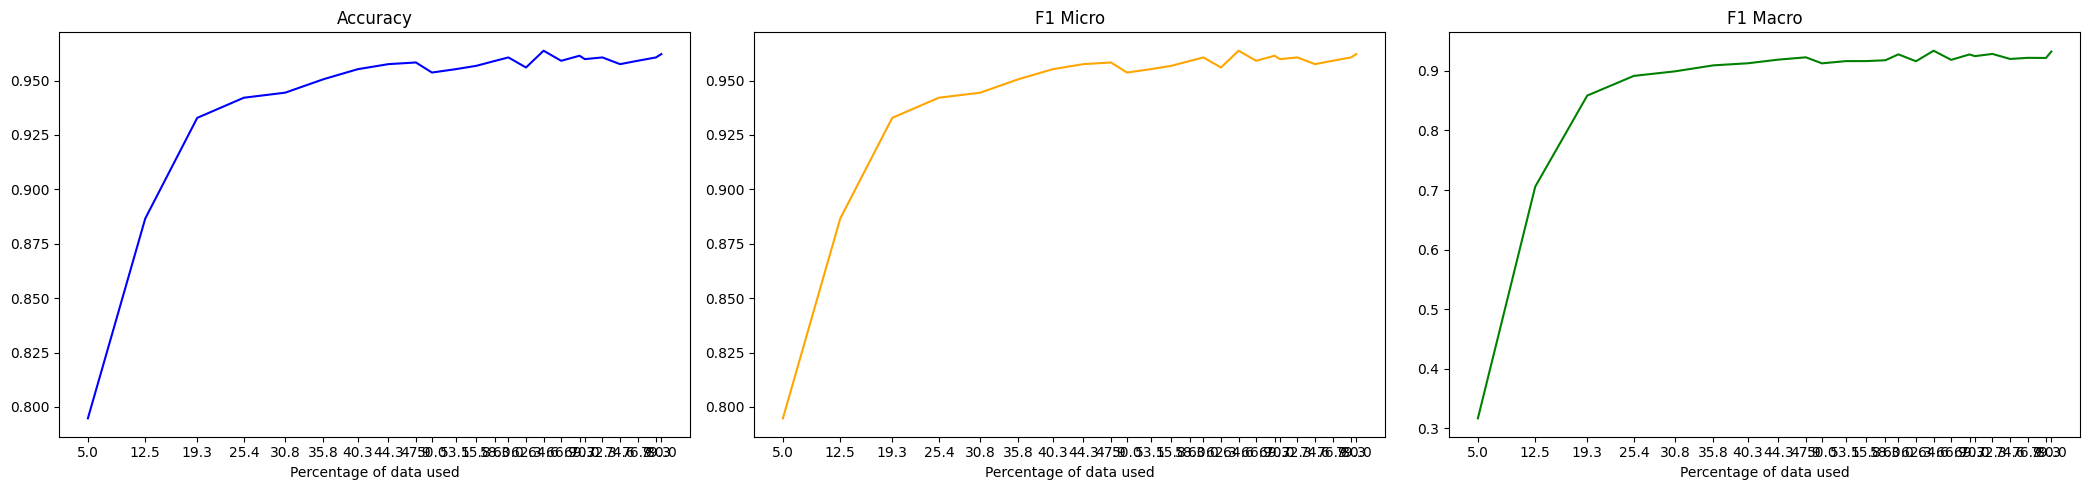

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6298, Accuracy: 0.7522, F1 Micro: 0.854, F1 Macro: 0.8362
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5654, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5262, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4783, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4582, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4326, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4132, Accuracy: 0.7924, F1 Micro: 0.8837, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4395, Accuracy: 0.7939, F1 Micro: 0.8842, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7142, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5719, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6151, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5677, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5123, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5138, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4932, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3579, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6049, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5195, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4816, Accuracy: 0.7961, F1 Micro: 0.8855, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4492, Accuracy: 0.7991, F1 Micro: 0.8866, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4084, Accuracy: 0.8125, F1 Micro: 0.8931, F1 Macro: 0.8915
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4057, Accuracy: 0.8147, F1 Micro: 0.8934, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.367, Accuracy: 0.8259, F1 Micro: 0.8984, F1 Macro: 0.8966
Epoch 8/10, Train Loss: 0.3229, Accuracy: 0.8237, F1 Micro: 0.8963, F1 Macro: 0.8928
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2746, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6562, Accuracy: 0.7708, F1 Micro: 0.7708, F1 Macro: 0.4353
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.549, Accuracy: 0.7708, F1 Micro: 0.7708, F1 Macro: 0.4353
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.553, Accuracy: 0.7778, F1 Micro: 0.7778, F1 Macro: 0.4664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4387, Accuracy: 0.7986, F1 Micro: 0.7986, F1 Macro: 0.7236
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3944, Accuracy: 0.8542, F1 Micro: 0.8542, F1 Macro: 0.8168
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.198, Accuracy: 0.8542, F1 Micro: 0.8542, F1 Macro: 0.8223
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.8542, F1 Micro: 0.8542, F1 Macro: 0.8196
Epoch 8/10, Train Loss: 0.1403, Accuracy: 0.8472, F1 Micro: 0.8472, F1 Macro: 0.8034
Epoch 9/10, Train Loss: 0.1183, Accuracy: 0.8472, F1 Micro: 0.8472, F1 Macro: 0.8034
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5814, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5218, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4933, Accuracy: 0.8013, F1 Micro: 0.887, F1 Macro: 0.8849
Epoch 4/10, Train Loss: 0.4744, Accuracy: 0.8028, F1 Micro: 0.8862, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.42, Accuracy: 0.8207, F1 Micro: 0.8963, F1 Macro: 0.8945
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3953, Accuracy: 0.8281, F1 Micro: 0.8987, F1 Macro: 0.8956
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.341, Accuracy: 0.8542, F1 Micro: 0.9132, F1 Macro: 0.911
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2843, Accuracy: 0.8884, F1 Micro: 0.9321, F1 Macro: 0.9293
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2146, Accuracy: 0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6317, Accuracy: 0.7316, F1 Micro: 0.7316, F1 Macro: 0.4225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4932, Accuracy: 0.7662, F1 Micro: 0.7662, F1 Macro: 0.6274
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3626, Accuracy: 0.8788, F1 Micro: 0.8788, F1 Macro: 0.8588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2313, Accuracy: 0.8874, F1 Micro: 0.8874, F1 Macro: 0.8688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1749, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8796
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1118, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8901
Epoch 7/10, Train Loss: 0.0986, Accuracy: 0.8961, F1 Micro: 0.8961, F1 Macro: 0.8727
Epoch 8/10, Train Loss: 0.1196, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8786
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8975
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5723, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.495, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4681, Accuracy: 0.8088, F1 Micro: 0.8913, F1 Macro: 0.8898
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.432, Accuracy: 0.8237, F1 Micro: 0.8976, F1 Macro: 0.8958
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3701, Accuracy: 0.8497, F1 Micro: 0.9108, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.304, Accuracy: 0.8973, F1 Micro: 0.9369, F1 Macro: 0.9329
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2373, Accuracy: 0.933, F1 Micro: 0.9588, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1998, Accuracy: 0.942, F1 Micro: 0.9638, F1 Macro: 0.9615
Epoch 9/10, Train Loss: 0.1454, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6, Accuracy: 0.6955, F1 Micro: 0.6955, F1 Macro: 0.4102
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4496, Accuracy: 0.8395, F1 Micro: 0.8395, F1 Macro: 0.8068
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2814, Accuracy: 0.8848, F1 Micro: 0.8848, F1 Macro: 0.8726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1856, Accuracy: 0.893, F1 Micro: 0.893, F1 Macro: 0.8824
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1886, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.8832
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.8724, F1 Micro: 0.8724, F1 Macro: 0.8451
Epoch 7/10, Train Loss: 0.1219, Accuracy: 0.8313, F1 Micro: 0.8313, F1 Macro: 0.8218
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1171, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.879
Epoch 9/10, Train Loss: 0.1014, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5576, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 2/10, Train Loss: 0.4882, Accuracy: 0.7872, F1 Micro: 0.8775, F1 Macro: 0.8727
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4576, Accuracy: 0.8222, F1 Micro: 0.8985, F1 Macro: 0.8975
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3933, Accuracy: 0.8616, F1 Micro: 0.9183, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3275, Accuracy: 0.9189, F1 Micro: 0.9504, F1 Macro: 0.9485
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2427, Accuracy: 0.9449, F1 Micro: 0.9659, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1856, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9687
Epoch 8/10, Train Loss: 0.1487, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9672
Epoch 9/10, Train Loss: 0.1172, Accuracy: 0.9494, F1 Micro: 0.9685, F1 Macro: 0.967
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6685, Accuracy: 0.6696, F1 Micro: 0.6696, F1 Macro: 0.401
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4002, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.8901
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2589, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.9052
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1716, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9197
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1004, Accuracy: 0.9391, F1 Micro: 0.9391, F1 Macro: 0.9329
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9304, F1 Micro: 0.9304, F1 Macro: 0.9233
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9304, F1 Micro: 0.9304, F1 Macro: 0.9233
Epoch 8/10, Train Loss: 0.1347, Accuracy: 0.887, F1 Micro: 0.887, F1 Macro: 0.8804
Epoch 9/10, Train Loss: 0.0823, Accuracy: 0.8739, F1 Micro: 0.8739, F1 Macro: 0.8466
Epoch 10/10, Train Loss: 0.0746, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5512, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4799, Accuracy: 0.8028, F1 Micro: 0.8889, F1 Macro: 0.8875
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4436, Accuracy: 0.8393, F1 Micro: 0.9071, F1 Macro: 0.9061
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3456, Accuracy: 0.8988, F1 Micro: 0.9391, F1 Macro: 0.9381
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2594, Accuracy: 0.9375, F1 Micro: 0.9614, F1 Macro: 0.9594
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1983, Accuracy: 0.9427, F1 Micro: 0.9643, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.149, Accuracy: 0.9516, F1 Micro: 0.9698, F1 Macro: 0.9682
Epoch 8/10, Train Loss: 0.111, Accuracy: 0.9472, F1 Micro: 0.9668, F1 Macro: 0.9648
Epoch 9/10, Train Loss: 0.0946, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6038, Accuracy: 0.6962, F1 Micro: 0.6962, F1 Macro: 0.4104
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4196, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.8883
Epoch 3/10, Train Loss: 0.2266, Accuracy: 0.8885, F1 Micro: 0.8885, F1 Macro: 0.8783
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9027
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1582, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.906
Epoch 6/10, Train Loss: 0.1553, Accuracy: 0.8846, F1 Micro: 0.8846, F1 Macro: 0.8744
Epoch 7/10, Train Loss: 0.1197, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9218
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8935
Epoch 10/10, Train Loss: 0.0506, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.548, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4713, Accuracy: 0.8155, F1 Micro: 0.895, F1 Macro: 0.8938
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4248, Accuracy: 0.8512, F1 Micro: 0.9134, F1 Macro: 0.9127
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.322, Accuracy: 0.9338, F1 Micro: 0.9594, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2266, Accuracy: 0.9501, F1 Micro: 0.9688, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1789, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1428, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1114, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.0894, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5726, Accuracy: 0.6865, F1 Micro: 0.6865, F1 Macro: 0.4957
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3606, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.9018
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2028, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9301
Epoch 4/10, Train Loss: 0.1789, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9108
Epoch 5/10, Train Loss: 0.1286, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9164
Epoch 6/10, Train Loss: 0.1321, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.9122
Epoch 7/10, Train Loss: 0.0993, Accuracy: 0.8968, F1 Micro: 0.8968, F1 Macro: 0.8882
Epoch 8/10, Train Loss: 0.0954, Accuracy: 0.881, F1 Micro: 0.881, F1 Macro: 0.8727
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0769, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9324
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0416, Accuracy: 0.9405, F1 Micro: 0.9405, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5396, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4748, Accuracy: 0.8013, F1 Micro: 0.8882, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4073, Accuracy: 0.8676, F1 Micro: 0.9221, F1 Macro: 0.9216
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3182, Accuracy: 0.936, F1 Micro: 0.9605, F1 Macro: 0.9586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.226, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.163, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1223, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9741
Epoch 8/10, Train Loss: 0.0978, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9717
Epoch 9/10, Train Loss: 0.0826, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.573, Accuracy: 0.8016, F1 Micro: 0.8016, F1 Macro: 0.7413
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.341, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9152
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2225, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9339
Epoch 5/10, Train Loss: 0.1794, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1743, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9335
Epoch 7/10, Train Loss: 0.0974, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9214
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9259
Epoch 9/10, Train Loss: 0.0856, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9241
Epoch 10/10, Train Loss: 0.0647, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5257, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4548, Accuracy: 0.817, F1 Micro: 0.8961, F1 Macro: 0.895
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3705, Accuracy: 0.8988, F1 Micro: 0.9391, F1 Macro: 0.9382
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2666, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9688
Epoch 5/10, Train Loss: 0.1892, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1369, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1151, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5558, Accuracy: 0.7619, F1 Micro: 0.7619, F1 Macro: 0.6465
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3164, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9286
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2057, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.929
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1837, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.932
Epoch 5/10, Train Loss: 0.1535, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9281
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1571, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9347
Epoch 7/10, Train Loss: 0.1329, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9224
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1103, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9379
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0864, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9425
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5293, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4706, Accuracy: 0.7991, F1 Micro: 0.8854, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4119, Accuracy: 0.878, F1 Micro: 0.9274, F1 Macro: 0.927
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2815, Accuracy: 0.9315, F1 Micro: 0.9574, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2122, Accuracy: 0.9509, F1 Micro: 0.9693, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1516, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1191, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9718
Epoch 8/10, Train Loss: 0.0959, Accuracy: 0.9524, F1 Micro: 0.97, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0785, Accuracy: 0.9606, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5741, Accuracy: 0.8333, F1 Micro: 0.8333, F1 Macro: 0.7883
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3345, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9238
Epoch 3/10, Train Loss: 0.2119, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.919
Epoch 4/10, Train Loss: 0.1504, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9224
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1674, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9238
Epoch 6/10, Train Loss: 0.1212, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9147
Epoch 7/10, Train Loss: 0.1334, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9224
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9092
Epoch 9/10, Train Loss: 0.0832, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9147
Epoch 10/10, Train Loss: 0.073, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9187

Sentiment analysis accuracy: 0.9341, F1 Micro: 0.93

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5255, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4636, Accuracy: 0.8199, F1 Micro: 0.897, F1 Macro: 0.8959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3689, Accuracy: 0.9204, F1 Micro: 0.9517, F1 Macro: 0.951
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2482, Accuracy: 0.9442, F1 Micro: 0.9653, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1829, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1433, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.108, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.0724, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5689, Accuracy: 0.8167, F1 Micro: 0.8167, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2942, Accuracy: 0.9243, F1 Micro: 0.9243, F1 Macro: 0.9175
Epoch 3/10, Train Loss: 0.2119, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.9052
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.137, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9323
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9342
Epoch 6/10, Train Loss: 0.1364, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.9134
Epoch 7/10, Train Loss: 0.1244, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.922
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9224
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9101
Epoch 10/10, Train Loss: 0.1042, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.9142

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5352, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4587, Accuracy: 0.8341, F1 Micro: 0.9047, F1 Macro: 0.9036
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3418, Accuracy: 0.942, F1 Micro: 0.9643, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2306, Accuracy: 0.9472, F1 Micro: 0.9671, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1714, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1231, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.1003, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9743
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.0657, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9748
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5153, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8764
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2796, Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.9467
Epoch 3/10, Train Loss: 0.206, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9181
Epoch 4/10, Train Loss: 0.1632, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9252
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9375
Epoch 6/10, Train Loss: 0.1098, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.934
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9414
Epoch 8/10, Train Loss: 0.0811, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.9063
Epoch 9/10, Train Loss: 0.0742, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9336
Epoch 10/10, Train Loss: 0.0472, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9386

Sentiment analysis accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.9467
            

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5405, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4615, Accuracy: 0.8304, F1 Micro: 0.9026, F1 Macro: 0.9017
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3574, Accuracy: 0.9338, F1 Micro: 0.9595, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2272, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1665, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1198, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0943, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9742
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9709
Epoch 9/10, Train Loss: 0.0662, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5665, Accuracy: 0.8867, F1 Micro: 0.8867, F1 Macro: 0.8695
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.299, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9436
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1557, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9472
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9422
Epoch 5/10, Train Loss: 0.1109, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9338
Epoch 6/10, Train Loss: 0.1087, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9192
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0996, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9475
Epoch 8/10, Train Loss: 0.0666, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9274
Epoch 9/10, Train Loss: 0.0672, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0624, Accuracy: 0.957, F1 Micro: 0.957, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5382, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4555, Accuracy: 0.8594, F1 Micro: 0.9176, F1 Macro: 0.9175
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3165, Accuracy: 0.9427, F1 Micro: 0.9645, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2009, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1108, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9726
Epoch 7/10, Train Loss: 0.0938, Accuracy: 0.9531, F1 Micro: 0.9705, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9606, F1 Micro: 0.975, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0621, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5245, Accuracy: 0.8721, F1 Micro: 0.8721, F1 Macro: 0.851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2723, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9273
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2097, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9396
Epoch 4/10, Train Loss: 0.1429, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1542, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9438
Epoch 6/10, Train Loss: 0.1486, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9355
Epoch 7/10, Train Loss: 0.0871, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9351
Epoch 8/10, Train Loss: 0.0709, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9273
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0811, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9441
Epoch 10/10, Train Loss: 0.0655, Accuracy: 0.938, F1 Micro: 0.938, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5316, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4533, Accuracy: 0.8661, F1 Micro: 0.9214, F1 Macro: 0.921
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3174, Accuracy: 0.9435, F1 Micro: 0.965, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2043, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.969
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.9509, F1 Micro: 0.9693, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1103, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.974
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9719
Epoch 8/10, Train Loss: 0.0707, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0608, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9748
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6006, Accuracy: 0.668, F1 Micro: 0.668, F1 Macro: 0.4005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3139, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.933
Epoch 3/10, Train Loss: 0.2075, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8938
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1756, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9345
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9269
Epoch 6/10, Train Loss: 0.1313, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9212
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1137, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9334
Epoch 8/10, Train Loss: 0.098, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9161
Epoch 9/10, Train Loss: 0.0971, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9307
Epoch 10/10, Train Loss: 0.0636, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.9109

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.525, Accuracy: 0.8006, F1 Micro: 0.8878, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4439, Accuracy: 0.8683, F1 Micro: 0.9227, F1 Macro: 0.9228
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3135, Accuracy: 0.9464, F1 Micro: 0.9668, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2138, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1464, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1146, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0658, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5605, Accuracy: 0.8901, F1 Micro: 0.8901, F1 Macro: 0.8664
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2633, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9146
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1807, Accuracy: 0.9304, F1 Micro: 0.9304, F1 Macro: 0.9206
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.9304, F1 Micro: 0.9304, F1 Macro: 0.9186
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.9078
Epoch 6/10, Train Loss: 0.1423, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9094
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.9267, F1 Micro: 0.9267, F1 Macro: 0.9176
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9267, F1 Micro: 0.9267, F1 Macro: 0.9189
Epoch 9/10, Train Loss: 0.085, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.9036
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0695, Accuracy: 0.9487, F1 Micro: 0.9487, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5311, Accuracy: 0.7999, F1 Micro: 0.8875, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4384, Accuracy: 0.8661, F1 Micro: 0.9208, F1 Macro: 0.9205
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3048, Accuracy: 0.942, F1 Micro: 0.964, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1991, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1088, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0605, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5067, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8889
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2559, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8989
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1885, Accuracy: 0.9569, F1 Micro: 0.9569, F1 Macro: 0.9516
Epoch 4/10, Train Loss: 0.1229, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1243, Accuracy: 0.9569, F1 Micro: 0.9569, F1 Macro: 0.9519
Epoch 6/10, Train Loss: 0.1067, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9351
Epoch 7/10, Train Loss: 0.0947, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9186
Epoch 8/10, Train Loss: 0.0799, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9328
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9477
Epoch 10/10, Train Loss: 0.0522, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9382

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5281, Accuracy: 0.8043, F1 Micro: 0.8897, F1 Macro: 0.8884
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4286, Accuracy: 0.881, F1 Micro: 0.9291, F1 Macro: 0.9284
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2834, Accuracy: 0.9472, F1 Micro: 0.9673, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1888, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1278, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.978
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9731
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9769
Epoch 10/10, Train Loss: 0.0484, Accuracy: 0.9643, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5193, Accuracy: 0.8984, F1 Micro: 0.8984, F1 Macro: 0.8912
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2633, Accuracy: 0.9309, F1 Micro: 0.9309, F1 Macro: 0.9254
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1565, Accuracy: 0.935, F1 Micro: 0.935, F1 Macro: 0.9299
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1419, Accuracy: 0.935, F1 Micro: 0.935, F1 Macro: 0.9292
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.909
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1049, Accuracy: 0.9431, F1 Micro: 0.9431, F1 Macro: 0.9371
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1069, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9426
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0848, Accuracy: 0.9512, F1 Micro: 0.9512, F1 Macro: 0.9451
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9414
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5281, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.433, Accuracy: 0.8817, F1 Micro: 0.9299, F1 Macro: 0.9289
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2936, Accuracy: 0.9449, F1 Micro: 0.9655, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1892, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0859, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5307, Accuracy: 0.8911, F1 Micro: 0.8911, F1 Macro: 0.8692
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.293, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9209
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.174, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9246
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9284
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1115, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9305
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9423
Epoch 9/10, Train Loss: 0.0654, Accuracy: 0.9455, F1 Micro: 0.9455,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5288, Accuracy: 0.7976, F1 Micro: 0.8864, F1 Macro: 0.8849
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4198, Accuracy: 0.9048, F1 Micro: 0.9422, F1 Macro: 0.941
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.267, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0964, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0801, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5064, Accuracy: 0.8937, F1 Micro: 0.8937, F1 Macro: 0.8817
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2127, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9251
Epoch 3/10, Train Loss: 0.1973, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9226
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1486, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9377
Epoch 5/10, Train Loss: 0.1385, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9189
Epoch 6/10, Train Loss: 0.1273, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9343
Epoch 7/10, Train Loss: 0.0851, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9289
Epoch 8/10, Train Loss: 0.0917, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9189
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9153
Epoch 10/10, Train Loss: 0.0475, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.9003

Sentiment analysis accuracy: 0.9449, F1 Micro: 0.94

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5244, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4146, Accuracy: 0.9055, F1 Micro: 0.9433, F1 Macro: 0.9425
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2602, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9752
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5035, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8878
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.247, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9146
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2036, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9386
Epoch 5/10, Train Loss: 0.1237, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9348
Epoch 6/10, Train Loss: 0.0809, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9268
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1068, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9435
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9141
Epoch 9/10, Train Loss: 0.0807, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.072, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5269, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4051, Accuracy: 0.9144, F1 Micro: 0.9479, F1 Macro: 0.9468
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2541, Accuracy: 0.9546, F1 Micro: 0.972, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9781
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9762
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5033, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8942
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2417, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9409
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9099
Epoch 4/10, Train Loss: 0.1388, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9317
Epoch 5/10, Train Loss: 0.1035, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9288
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9263
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9369
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.9052
Epoch 9/10, Train Loss: 0.084, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.913
Epoch 10/10, Train Loss: 0.0506, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9328

Sentiment analysis accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9409
              p

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5218, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4099, Accuracy: 0.907, F1 Micro: 0.9438, F1 Macro: 0.9427
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2525, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9561, F1 Micro: 0.9722, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0924, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4463, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.9038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2063, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9161
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1477, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9242
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1361, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9316
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1095, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9446
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9402
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9443
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9402
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9533, F1 Micro: 0.9533, F1 Macro: 0.9473
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5143, Accuracy: 0.7984, F1 Micro: 0.8868, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3927, Accuracy: 0.9219, F1 Micro: 0.9525, F1 Macro: 0.9509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2392, Accuracy: 0.9494, F1 Micro: 0.9682, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9772
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9746
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9795
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4967, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.9065
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2308, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9303
Epoch 3/10, Train Loss: 0.1647, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.898
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.146, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9387
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1284, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9393
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.102, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9432
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9307
Epoch 8/10, Train Loss: 0.0794, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9228
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9269
Epoch 10/10, Train Loss: 0.1153, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro

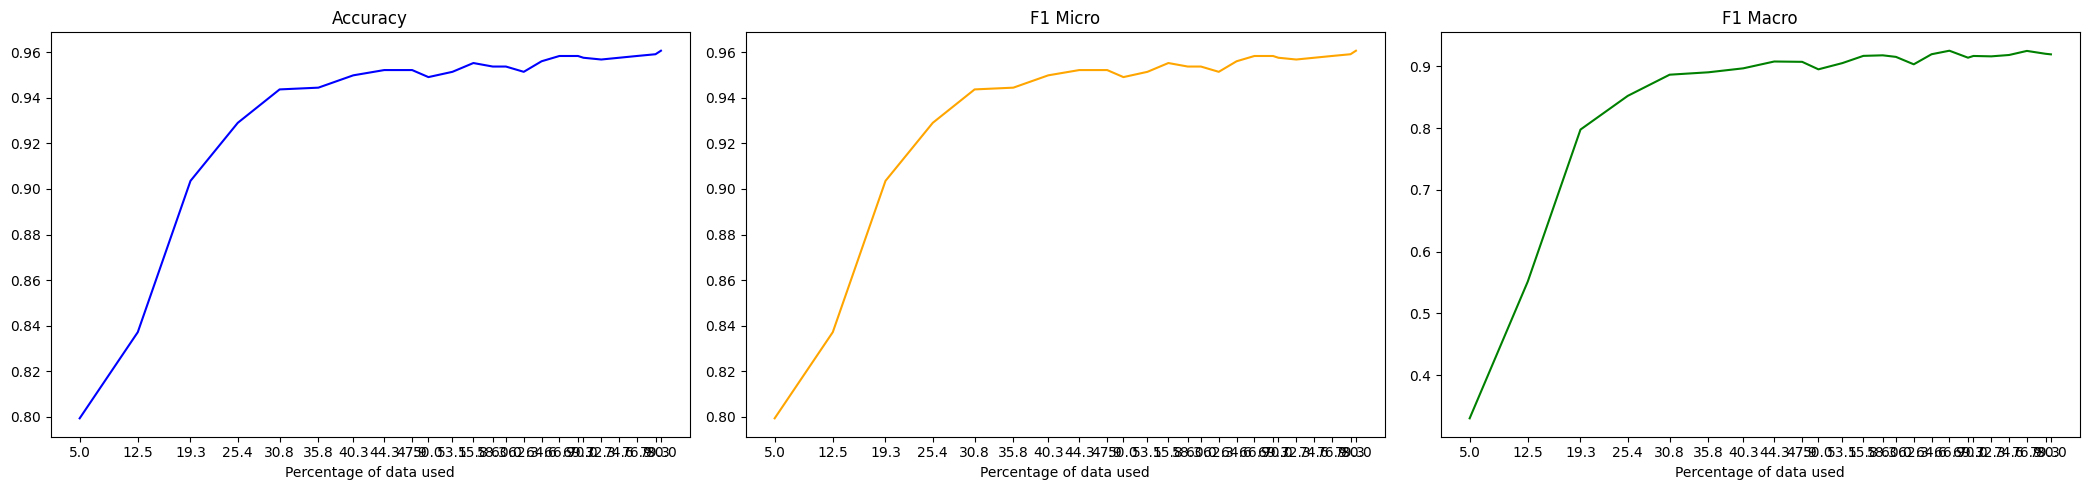

In [ ]:
active_learning(seeds[4], 4)